# Projet 7: Preuve de concept

## contexte :
Utiliser les Transformers sur des données tabulées comme proposé par Huang et al, 2020
Utilisation d'une base de données réelles créées à partir de données publiques télécheargeables sur data.gouv.fr
A partir de cette base de données, des modèles seront créés afin de prédire le prix de l'immobilier en Ile de France.
Des modèles "baseline" seront utilisés pour conclure sur l'efficacité du TabTransformer.

## démarches
- télécharger les données
- nettoyage et exploration
- combiner l'ensemble des données
- créer de nouvelles variables
- Modélisation

# Notebook de création de la base de données
Dans ce notebook, les données seront chargées, nettoyées et la base de données utilisée pour la modélisation sera sauvegardée.

## Modules Python

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
try :
    import wget
except :
    !pip install wget
    import wget

In [3]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

## Téléchargement des données

In [4]:
#DIR = '/data'
DIR = './'
DIR_immo = DIR+"/data_immo"
DIR_transp = DIR+"/data_transport"
DIR_loyer = DIR+"/data_loyer"
DIR_educ = DIR+"/data_education"
DIR_com = DIR+"/data_communes"

### Données ventes immobilières
L'historique des ventes immobilières sont disponibles et téléchargeables dans le catalogue :  
 https://files.data.gouv.fr/geo-dvf/latest
 

In [4]:
for year in [2017, 2018, 2019, 2020, 2021 ] :
    odir = f"{DIR_immo}/{year}"
    if not os.path.isdir(odir) :
        os.makedirs(odir)
    if os.path.isfile(f"{odir}/91.csv.gz"):
        os.remove(f"{odir}/91.csv.gz")
    url = f"https://files.data.gouv.fr/geo-dvf/latest/csv/{year}/departements/91.csv.gz"
    wget.download(url, out=f"{odir}/91.csv.gz")

### Données transports en communs

In [5]:
if not os.path.isdir(DIR_transp):
    os.makedirs(DIR_transp)
#url = "https://data.iledefrance-mobilites.fr/api/v2/catalog/datasets/offre-horaires-tc-gtfs-idfm/files/a925e164271e4bca93433756d6a340d1"
#url = "https://www.data.gouv.fr/fr/datasets/r/9000a96a-f17e-4e97-853e-330cf089dbf7"
url = "https://www.data.gouv.fr/fr/datasets/r/34c7e096-f984-4b74-8d3c-a379a6762f42"
wget.download(url, out=DIR_transp)
    

'.//data_transport/emplacement-des-gares-idf (1).csv'

### Données loyers
Les données sur les valeurs locatives moyennes par communes ont été synthétisées et téléchargeable sur :
- maisons : https://www.data.gouv.fr/fr/datasets/r/cf39b7e5-12fb-48e9-9ee7-b7e5496dcb75
- appartements : https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da

In [6]:
if not os.path.isdir(DIR_loyer) :
    os.makedirs(DIR_loyer)
url_appart = "https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da"
url_maison = "https://www.data.gouv.fr/fr/datasets/r/cf39b7e5-12fb-48e9-9ee7-b7e5496dcb75"
for file in [f"{DIR_loyer}/loyer_appartements.csv", f"{DIR_loyer}/loyer_maisons.csv"] : 
    if os.path.isfile(file) :
        os.remove(file)
wget.download(url_appart, out=f"{DIR_loyer}/loyer_appartements.csv")
wget.download(url_maison, out=f"{DIR_loyer}/loyer_maisons.csv")

'.//data_loyer/loyer_maisons.csv'

### Données éducations

In [7]:
if not os.path.isdir(DIR_educ) :
    os.makedirs(DIR_educ)

#### Ecoles, collèges et lycées
La liste des écoles, collèges et lycées sont disponibles sur le site du ministère de l'éducation nationale à l'adresse :
https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B

In [8]:
url_ecole = "https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"
if os.path.isfile(f"{DIR_educ}/liste_ecole.csv") :
    os.remove(f"{DIR_educ}/liste_ecole.csv")
wget.download(url_ecole, out=f"{DIR_educ}/liste_ecole.csv")

'.//data_education/liste_ecole.csv'

#### Universités
La liste des universités est disponible à l'adresse suivante :  
https://www.data.gouv.fr/fr/datasets/r/bcc3229a-beb2-4077-a8d8-50a065dfbbfa

In [9]:
url_univ = "https://www.data.gouv.fr/fr/datasets/r/bcc3229a-beb2-4077-a8d8-50a065dfbbfa"
if os.path.isfile(f"{DIR_educ}/liste_universite.csv") :
    os.remove(f"{DIR_educ}/liste_universite.csv")
wget.download(url_univ, out=f"{DIR_educ}/liste_universite.csv")

'.//data_education/liste_universite.csv'

### Données sur les communes

In [10]:
filename = "data_insee.xls"
if not  os.path.isdir(DIR_com):
    os.makedirs(DIR_com)
#url = "https://www.data.gouv.fr/fr/datasets/r/05cc86c4-b499-40c9-84cc-fd24d92d4a45"
url = "https://static.data.gouv.fr/resources/data-insee-sur-les-communes/20141212-105948/MDB-INSEE-V2.xls"
if os.path.isfile(f"{DIR_com}/{filename}") : 
    os.remove(f"{DIR_com}/{filename}")
wget.download(url, out=f"{DIR_com}/{filename}")

'.//data_communes/data_insee.xls'

## Chargement des données

### Données ventes immobilières

In [5]:
filename = "91.CSV.gz"
for i, year in enumerate([2017, 2018, 2019, 2020, 2021]) :
    idir = f"{DIR_immo}/{year}"
    if i == 0 :
        DATA_immo = pd.read_csv(f"{idir}/{filename}", compression="gzip", sep=",", low_memory=False)
        columns = DATA_immo.columns
        print(f"Nombre de ventes en {year} : {len(DATA_immo)}")
    else : 
        tmp = pd.read_csv(f"{idir}/{filename}", compression="gzip", sep=",", low_memory=False)
        if not np.array_equal(tmp.columns, columns) :
            print(f"Changement de format pour l'année {year}")
            raise 
        print(f"Nombre de ventes en {year} : {len(tmp)}")
        DATA_immo = pd.concat([DATA_immo, tmp], ignore_index=True)
print(f"Nombre total de ventes sur la période : {len(DATA_immo)}")

Nombre de ventes en 2017 : 57096
Nombre de ventes en 2018 : 46302
Nombre de ventes en 2019 : 53083
Nombre de ventes en 2020 : 44354
Nombre de ventes en 2021 : 57004
Nombre total de ventes sur la période : 257839


### Données transports en communs

In [7]:
DATA_transp = pd.read_csv("data_transport/emplacement-des-gares-idf.csv", low_memory=False, sep=";")
print(f"Nombre de stations : {len(DATA_transp)}")

Nombre de stations : 1182


### Données loyers

In [8]:
DATA_appart = pd.read_csv(f"{DIR_loyer}/loyer_appartements.csv", encoding = "ISO-8859-1",low_memory=False, sep=";")
DATA_maison = pd.read_csv(f"{DIR_loyer}/loyer_maisons.csv", encoding = "ISO-8859-1",low_memory=False, sep=";")
print(f"Nombre de communes dont les données sur les loyers des appartements sont connues : {len(DATA_appart)}")
print(f"Nombre de communes dont les données sur les loyers des maisons sont connues : {len(DATA_maison)}")

Nombre de communes dont les données sur les loyers des appartements sont connues : 35441
Nombre de communes dont les données sur les loyers des maisons sont connues : 35441


### Educations

#### Ecoles, collèges et lycées

In [9]:
DATA_ecole = pd.read_csv(f"{DIR_educ}/liste_ecole.csv", low_memory=False, sep=";")
print(f"Nombre d'école référencées : {len(DATA_ecole)}")

Nombre d'école référencées : 65526


#### Universités

In [10]:
DATA_univ = pd.read_csv(f"{DIR_educ}/liste_universite.csv", low_memory=False, sep=";")
print(f"Nombre d'universités référencées : {len(DATA_univ)}")

Nombre d'universités référencées : 255


### Données sur les communes

In [11]:
DATA_com = pd.read_excel(f"{DIR_com}/data_insee.xls")
print(f"Nombre de communes : {len(DATA_com)}")

WARNING *** file size (57125979) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Nombre de communes : 36677


## Nettoyage des données
Le but de cette partie est de supprimer les variables qui ne seront pas utilisées pour économiser de l'espace mémoire, mais aussi de supprimer les données abérantes.

### Données ventes immobilières

- N° de disposition: Quand un même acte de vente comporte plusieurs biens, plusieurs lignes de transactions seront enregistrées avec le même numéro de disposition. Il s'agit donc d'un identifiant unique d'un acte de vente.
- Date de mutation: Date de signature de l'acte de vente. elle est actuellement comprise entre le 1er janvier 2014 et le 31 Décembre 2021 en attendant la mise à jour de nouvelles transactions immobilières.
- Nature de la mutation: Il s'agit du type de vente qui a eu lieu. Il peut s'agir d'une vente classique, d'une vente en l’état futur d’achèvement, d'une vente de terrain à bâtir, d'une adjudication, ou d'une expropriation ou échange.
- Valeur foncière: Montant de la vente. Ce montant ne comprend pas les frais de notaire et les frais d'agence car il correspond finalement à la valeur du bien vendu. Ce montant est TTC.
- Adresse: L'adresse exacte du bien est communiquée via plusieurs colonnes comme le numéro de voie, le code postal etc.
- Informations cadastrales: Des informations cadastrales sont fournies telles que le Numéro de section ou le numéro de plan.
- Lots et surfaces: Un lot de copropriété est constitué d’une partie privative (appartement, cave, etc.) et d’une quote-part de partie commune (tantièmes). Seuls les 5 premiers lots sont mentionnés. Si le nombre de lots est supérieur à 5, ils ne sont pas restitués.
- Nombre de lots: Nombre total de lots par disposition.
- Type de local: Il peut s'agir d'une maison, d'un appartement, d'une dépendance (isolée), ou d'un local industriel et commercial ou assimilés.
- Surface réelle bâti: Il s'agit de la surface réelle mesurée au sol entre les murs.
- Nombre de pièces principales: nombre de pièces principales du bien immobilier.
- Nature culture: Pour les terrains une nature de culture est renseignée afin de connaître son utilisation. Les types de terrains possible sont : terrains a bâtir, terrains d'agrément, bois, futaies feuillues, futaies mixtes, oseraies, peupleraies, futaies résineuses, taillis sous futaie, taillis simples, carrières, chemin de fer, eaux, jardins, landes, landes boisées, prés, pâtures, pacages, prés d'embouche, herbages, prés plantes, sols, terres, terres plantées, vergers, vignes
- Surface Terrain: Surface cadastrale du terrain.

#### Variables disponibles

In [6]:
len(DATA_immo.columns)

40

In [18]:
DATA_immo.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2017-1258467,2017-01-02,1,Vente en l'état futur d'achèvement,255000.0,NaN,NaN,LA PRIEUREE,B020,91070.0,91086,Bondoufle,91,NaN,NaN,910860000B0464,NaN,NaN,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-1258467,2017-01-02,1,Vente en l'état futur d'achèvement,255000.0,NaN,NaN,LA PRIEUREE,B020,91070.0,91086,Bondoufle,91,NaN,NaN,910860000B0464,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-1258468,2017-01-03,1,Vente,70500.0,7.0,NaN,RUE DE L'HOPITAL,2259,91100.0,91174,Corbeil-Essonnes,91,NaN,NaN,91174000AV0266,NaN,NaN,3.0,28.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,28.0,1.0,NaN,NaN,NaN,NaN,NaN,2.479872,48.597344
3,2017-1258468,2017-01-03,1,Vente,70500.0,59.0,B,BD HENRI DUNANT,2250,91100.0,91174,Corbeil-Essonnes,91,NaN,NaN,91174000AV0266,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.479872,48.597344
4,2017-1258469,2017-01-03,1,Vente,116000.0,2.0,NaN,RUE LAVOISIER,0140,91080.0,91228,Évry-Courcouronnes,91,91182.0,Courcouronnes,91228182AC0001,91182000AC0001,NaN,38.0,53.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,49.0,2.0,NaN,NaN,NaN,NaN,NaN,2.403528,48.617923


In [19]:
DATA_immo.dtypes

id_mutation                      object
date_mutation                    object
numero_disposition                int64
nature_mutation                  object
valeur_fonciere                 float64
adresse_numero                  float64
adresse_suffixe                  object
adresse_nom_voie                 object
adresse_code_voie                object
code_postal                     float64
code_commune                      int64
nom_commune                      object
code_departement                  int64
ancien_code_commune             float64
ancien_nom_commune               object
id_parcelle                      object
ancien_id_parcelle               object
numero_volume                    object
lot1_numero                      object
lot1_surface_carrez             float64
lot2_numero                      object
lot2_surface_carrez             float64
lot3_numero                      object
lot3_surface_carrez             float64
lot4_numero                      object


In [20]:
DATA_immo.describe()

,numero_disposition,valeur_fonciere,adresse_numero,code_postal,code_commune,code_departement,ancien_code_commune,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
count,257839.000000,2.562290e+05,207998.000000,253243.000000,257839.000000,257839.0,5813.000000,39985.000000,8326.000000,746.000000,191.000000,740.000000,99.000000,257839.000000,195654.000000,127914.000000,195544.000000,125035.000000,246427.000000,246427.000000
mean,1.716726,3.053815e+06,593.239094,91366.417275,91356.856356,91.0,91226.485808,66.592704,65.970631,71.781743,85.929686,163.598649,133.486970,0.655312,2.169273,111.657856,2.166413,10664.324765,2.323232,48.630460
std,4.508014,1.217457e+07,2157.003719,229.956710,198.929323,0.0,47.581762,132.795051,90.982575,90.793919,85.277288,771.690592,121.137433,1.053889,0.873217,674.817999,2.109562,52350.400396,0.120993,0.090132
min,1.000000,1.500000e-01,1.000000,91000.000000,91001.000000,91.0,91182.000000,1.000000,0.800000,0.890000,8.000000,2.000000,0.930000,0.000000,1.000000,1.000000,0.000000,1.000000,1.924273,48.288600
25%,1.000000,1.500000e+05,5.000000,91180.000000,91195.000000,91.0,91182.000000,42.530000,50.820000,41.577500,38.500000,9.000000,47.470000,0.000000,1.000000,52.000000,0.000000,273.000000,2.249954,48.594693
50%,1.000000,2.350000e+05,16.000000,91310.000000,91345.000000,91.0,91228.000000,61.250000,64.120000,59.710000,59.770000,39.000000,75.500000,1.000000,2.000000,71.000000,2.000000,505.000000,2.329343,48.648797
75%,1.000000,4.000000e+05,40.000000,91540.000000,91540.000000,91.0,91228.000000,76.640000,75.965000,77.840000,103.760000,112.000000,209.670000,1.000000,3.000000,96.000000,4.000000,1218.500000,2.420854,48.697285
max,171.000000,4.352450e+08,9999.000000,91940.000000,91692.000000,91.0,91390.000000,8062.000000,7108.000000,2040.230000,559.900000,17013.000000,567.430000,91.000000,4.000000,142124.000000,109.000000,440922.000000,2.584422,48.775551


In [21]:
count = DATA_immo['id_mutation'].value_counts()
len(count[count==1])

54795

#### Suppression des variables inutilisées
Parmis les variables disponibles, les variables suivantes seront supprimées :
- numero_disposition : l'identifiant du bien de la vente ne sera pas utilisé
- ancien_code_commune, ancien_nom_commune : on utilise uniquement les noms actuels
- id_parcelle, ancien_id_parcelle : l'identifiant de la parcelle ne sera pas utilisé car c'est une information trop précise de la localisation
- les numéros de lots : aucune influence sur le prix
- code_type_local, code_nature_culture, code_nature_culture_speciale : le code sera recréé
- adresse_numero, adresse_suffixe, adresse_nom_voie, adresse_code_voie : on ne prend pas en compte l'adresse
- code_postal, nom commune : ces informations sont disponibles dans la base de données sur les communes

In [22]:
rm_var = ['ancien_code_commune', 'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',\
         'lot1_numero', 'lot2_numero', 'lot3_numero', 'lot4_numero', 'lot5_numero', 'code_type_local', 'code_nature_culture',\
         'code_nature_culture_speciale', 'numero_disposition', 'adresse_numero', 'adresse_suffixe', \
          'adresse_nom_voie', 'adresse_code_voie', 'numero_volume', 'code_postal', 'nom_commune']
for var in rm_var :
    if var in DATA_immo.columns :
        DATA_immo.drop(var, axis='columns', inplace=True)
    else :
        print(f"{var} n'est pas dans la base de données")

In [23]:
print(f"Nombre de variables restantes : {len(DATA_immo.columns)}")
print(f"Variables restantes : {', '.join(DATA_immo.columns)}")

Nombre de variables restantes : 20
Variables restantes : id_mutation, date_mutation, nature_mutation, valeur_fonciere, code_commune, code_departement, lot1_surface_carrez, lot2_surface_carrez, lot3_surface_carrez, lot4_surface_carrez, lot5_surface_carrez, nombre_lots, type_local, surface_reelle_bati, nombre_pieces_principales, nature_culture, nature_culture_speciale, surface_terrain, longitude, latitude


In [24]:
DATA_immo['n_lignes'] = [1]*len(DATA_immo)

#### regrouprement des ventes 

In [25]:
counts = DATA_immo['id_mutation'].value_counts()
print(len(counts))

118439


In [26]:
def join_str(l) :
    out = ""
    for val in l : 
        if val != np.NaN  :
            if out == "" : 
                out += f"{str(val)}"
            else :
                out += f", {str(val)}"
    if out == "" :
        return "nan"
    else :
        return out
    #return ', '.join(set(l.astype(str)))

In [27]:
aggs = {
    'surface_reelle_bati' : sum,
    'date_mutation' : min,
    'valeur_fonciere' : 'mean',
    'code_departement' : 'mean',
    'nombre_lots' : sum,
    'n_lignes': sum,
    'nombre_pieces_principales': sum,
    'surface_terrain': sum,
    'longitude' : 'mean',
    'latitude' : 'mean',
    'type_local': join_str
}
for n in range(1,6):
    aggs[f"lot{n}_surface_carrez"] = sum

for var in ['nature_mutation', 'code_commune', 'nature_culture','type_local', 'nature_culture_speciale'] :
    aggs[var] = join_str

In [28]:
DATA_immo = DATA_immo.groupby('id_mutation').agg(aggs)

In [29]:
DATA_immo = DATA_immo.reset_index()

#### type_local

In [30]:
DATA_immo['type_local']

0                                                  nan, nan
1                                   Appartement, Dépendance
2                                               Appartement
3                       Dépendance, Appartement, Dépendance
4                                               Appartement
                                ...                        
118434                                               Maison
118435    Dépendance, Appartement, Dépendance, Dépendanc...
118436                                          Maison, nan
118437                  Appartement, Dépendance, Dépendance
118438    Local industriel. commercial ou assimilé, Loca...
Name: type_local, Length: 118439, dtype: object

In [31]:
counter = pd.DataFrame()
for i in range(len(DATA_immo)) :
    tmp={}
    l = DATA_immo.iloc[i]['type_local'].split(', ')
    for element in set(l) :
        tmp[element] = l.count(element)
    counter = counter.append(tmp, ignore_index=True)
counter.fillna(0)

,nan,Appartement,Dépendance,Maison,Local industriel. commercial ou assimilé
0,2.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,2.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
118434,0.0,0.0,0.0,1.0,0.0
118435,0.0,1.0,4.0,0.0,0.0
118436,1.0,0.0,0.0,1.0,0.0
118437,0.0,1.0,2.0,0.0,0.0


In [32]:
DATA_immo = DATA_immo.join(counter.fillna(0))

Dans ce projet on s'intéresse uniquement aux valeurs des maisons et appartements. On supprime donc toutes les ventes avec des locaux commerciaux et celles qui contient uniquement des dépendances. On supprime également les ventes dont le type n'est pas spécifié.  
La base de données contient des mutations avec plusieurs biens. Il est possible que cela fausse l'estimation du prix, de ce fait on conserve uniquement les mutations avec une maison ou un appartement seulement.

In [33]:
DATA_immo.drop(DATA_immo[DATA_immo['Local industriel. commercial ou assimilé'] > 0].index, inplace=True)

In [34]:
DATA_immo.drop(DATA_immo[(DATA_immo['Appartement'] == 0) & (DATA_immo['Maison'] == 0)].index, inplace=True)

In [35]:
i_maison = DATA_immo[(DATA_immo['Maison'] == 1) & (DATA_immo['Appartement'] == 0)].index.values
i_appart = DATA_immo[(DATA_immo['Maison'] == 0) & (DATA_immo['Appartement'] == 1)].index.values

In [36]:
DATA_immo = DATA_immo[DATA_immo.index.isin(list(i_maison)+list(i_appart))]

In [37]:
type_local = pd.Series(data=[DATA_immo[var].sum() for var in ['Appartement', 'Maison', 'Dépendance']], 
                       index=['Appartement', 'Maison', 'Dépendance'])

<AxesSubplot:>

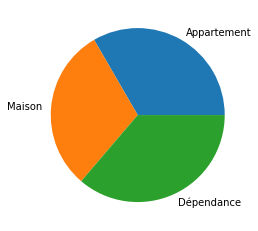

In [38]:
type_local.plot.pie(ylabel='')

In [39]:
print(f"Nombre de ventes restantes : {len(DATA_immo)}")

Nombre de ventes restantes : 83199


In [40]:
DATA_immo.drop(['nan', 'type_local', 'Local industriel. commercial ou assimilé'], axis='columns', inplace=True)

count    83199.000000
mean         0.568805
std          0.854171
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         75.000000
Name: Dépendance, dtype: float64


<AxesSubplot:>

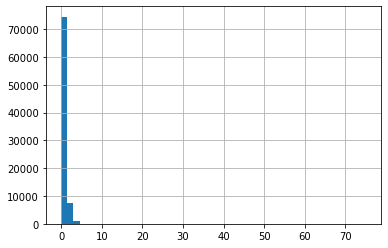

In [41]:
print(DATA_immo['Dépendance'].describe())
DATA_immo['Dépendance'].hist(bins=50)

Certaine mutation ont un nombre important de dépendances. On détermine comme outlier toutes les mutations avec un nombre de dépendances supérieur à 3.

In [42]:
DATA_immo.drop(DATA_immo[DATA_immo['Dépendance'] > 3].index, inplace=True)

count    83043.000000
mean         1.678576
std          0.945955
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         98.000000
Name: n_lignes, dtype: float64


<AxesSubplot:>

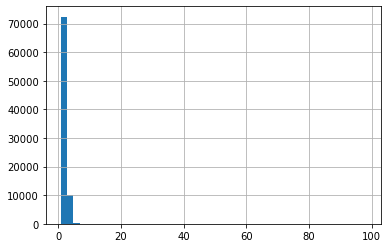

In [43]:
print(DATA_immo['n_lignes'].describe())
DATA_immo['n_lignes'].hist(bins=50)

Certaines mutation comportent un grand nombre de biens non répertoriés. Puisqu'il est impossible de la caractériser, on les supprime.

In [44]:
DATA_immo.drop(DATA_immo[DATA_immo['n_lignes'] > 3].index, inplace=True)

On recrée une variable categorielle sur le type de local, qui peut prendre que deux valeurs : Maison ou appartement.

In [45]:
def create_local_type(x) :
    if x.Maison == 1 and x.Appartement == 0 :
        return 'Maison'
    elif x.Maison == 0 and x.Appartement == 1 :
        return 'Appartement' 
    else :
        print(x.Maison, x.Appartement)
        return None

In [46]:
DATA_immo['type_local'] = DATA_immo.apply(create_local_type, axis=1)

In [47]:
DATA_immo.drop(['Appartement', 'Maison'], axis=1, inplace=True)

#### date_mutation

In [48]:
DATA_immo['date_mutation'] = DATA_immo['date_mutation'].astype('datetime64[ns]')

In [49]:
print(f"Vente la plus ancienne : {DATA_immo['date_mutation'].min()}")
print(f"Vente la plus récente : {DATA_immo['date_mutation'].max()}")

Vente la plus ancienne : 2017-01-02 00:00:00
Vente la plus récente : 2021-12-31 00:00:00


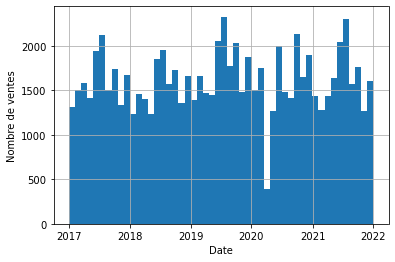

In [50]:
fig, ax = plt.subplots()
DATA_immo['date_mutation'].hist(bins=50, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel("Nombre de ventes")
plt.show()

On remarque que les ventes sont bien réparties sur toute la période.  
On remarque une période de creux correspondant au confinement de la COVID, et un pic tous les ans en été.

On créé deux nouvelles variables indiquant l'année de la vente et le mois qui peut avoir un impact sur le prix de vente.

In [51]:
DATA_immo['année'] = DATA_immo['date_mutation'].dt.year

In [52]:
DATA_immo['mois'] = DATA_immo['date_mutation'].dt.month

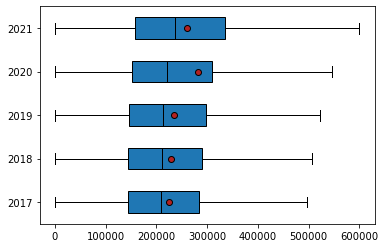

In [53]:
data = DATA_immo[pd.notnull(DATA_immo['année'])]
data = data[pd.notnull(data['valeur_fonciere'])]
modalites = data['année'].unique()
groupes = []
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
             'markerfacecolor':'firebrick'}

for mod in modalites : 
    groupes.append(data[data['année']==mod]['valeur_fonciere'])
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

La représentation des valeurs foncières en fonction des années montre une légère augmentation des prix moyen entre 2017 et 2021, avec l'année 2020 qui est l'année où les ventes on était les plus importantes en moyennes.

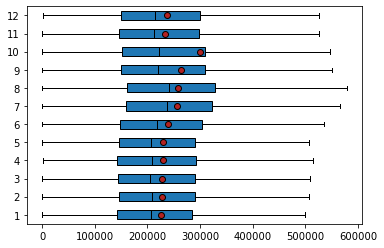

In [54]:
data = DATA_immo[pd.notnull(DATA_immo['mois'])]
data = data[pd.notnull(data['valeur_fonciere'])]
modalites = data['mois'].unique()
groupes = []
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
             'markerfacecolor':'firebrick'}

for mod in modalites : 
    groupes.append(data[data['mois']==mod]['valeur_fonciere'])
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

La valeur moyenne des mutations n'est pas constante en fonction du mois de l'année. En moyenne les prix sont plus élevés entre juillet et octobre.

#### nature_mutation

In [55]:
DATA_immo['nature_mutation'] = DATA_immo['nature_mutation'].str.split(', ').apply(set)

In [56]:
DATA_immo[DATA_immo['nature_mutation'].apply(len) > 1]

,id_mutation,surface_reelle_bati,date_mutation,valeur_fonciere,code_departement,nombre_lots,n_lignes,nombre_pieces_principales,surface_terrain,longitude,latitude,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nature_mutation,code_commune,nature_culture,nature_culture_speciale,Dépendance,type_local,année,mois
6463,2017-1264930,66.0,2017-10-27,140000.0,91.0,4,3,3.0,0.0,2.48935,48.675023,59.1,65.0,0.0,0.0,0.0,"{Vente, Vente en l'état futur d'achèvement}","91215, 91215, 91228","nan, nan, nan","nan, nan, nan",1.0,Appartement,2017,10


On supprime les observations qui ont plusieurs natures de mutation

In [57]:
DATA_immo.drop(DATA_immo[DATA_immo['nature_mutation'].apply(len) > 1].index, inplace=True)

In [58]:
DATA_immo['nature_mutation'] = DATA_immo['nature_mutation'].apply(lambda x : list(x)[0])

In [59]:
counts = DATA_immo['nature_mutation'].value_counts(dropna=False)
counts

Vente                                 76031
Vente en l'état futur d'achèvement     4649
Adjudication                            320
Echange                                  40
Vente terrain à bâtir                    21
Expropriation                             2
Name: nature_mutation, dtype: int64

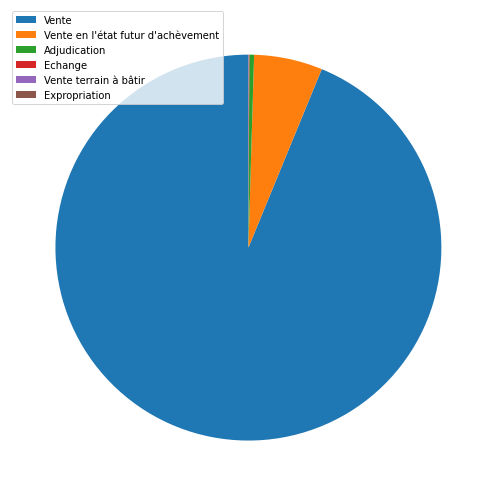

In [60]:
fig, ax = plt.subplots(figsize=(7,7))
wedges,_ = ax.pie(counts, shadow=False,startangle=90,textprops={'fontsize': 10})
ax.legend(counts.index)
plt.tight_layout()

Les terrains à batir ne nous intéressent pas, on les supprime.

In [61]:
 DATA_immo.drop(DATA_immo[DATA_immo['nature_mutation'] == 'Vente terrain à bâtir'].index, inplace=True)

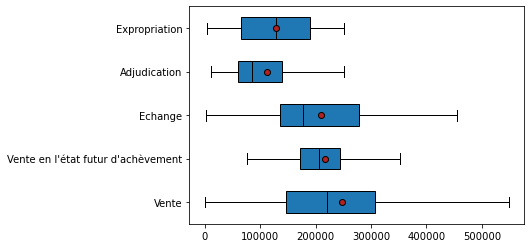

In [62]:
data = DATA_immo[pd.notnull(DATA_immo['nature_mutation'])]
data = data[pd.notnull(data['valeur_fonciere'])]
modalites = data['nature_mutation'].unique()
groupes = []
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
             'markerfacecolor':'firebrick'}

for mod in modalites : 
    groupes.append(data[data['nature_mutation']==mod]['valeur_fonciere'])
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

La valeur foncière des ventes, vente en l'état futur et échange sont similaire.  Par contre les valeurs des expropriation et des adjudication sur sensiblement inférieures.

#### valeur_fonciere

In [63]:
count_nan = DATA_immo['valeur_fonciere'].isnull().value_counts()
count_nan

False    81019
True        23
Name: valeur_fonciere, dtype: int64

On supprime les observations dont on ne connait pas la valeur foncière.

In [64]:
DATA_immo.drop(DATA_immo[DATA_immo['valeur_fonciere'].isnull()].index, inplace=True)

In [65]:
print(f"Prix minimum : {DATA_immo['valeur_fonciere'].min()}")
print(f"Prix maximum : {DATA_immo['valeur_fonciere'].max()}")
print(f"Prix moyen : {DATA_immo['valeur_fonciere'].mean()}")
print(f"Prix median : {DATA_immo['valeur_fonciere'].median()}")


Prix minimum : 1.0
Prix maximum : 435244992.0
Prix moyen : 245584.00366617742
Prix median : 217800.0


In [66]:
DATA_immo['valeur_fonciere'].describe()

count    8.101900e+04
mean     2.455840e+05
std      1.655151e+06
min      1.000000e+00
25%      1.492000e+05
50%      2.178000e+05
75%      3.030000e+05
max      4.352450e+08
Name: valeur_fonciere, dtype: float64

Certains biens ont des valeurs très élevées mais ne sont pas en assez grand nombre pour être caractérisés. On se limite aux biens avec une valeur inférieurs à 1M €.

In [67]:
DATA_immo.drop(DATA_immo[DATA_immo['valeur_fonciere']>1e6].index, inplace=True)

Certains biens ont des valeurs foncières très faibles. N'ayant pas connaissance de l'état de l'habitation, on supprime ces observations qui apparaissent aberrantes.

In [68]:
DATA_immo.drop(DATA_immo[DATA_immo['valeur_fonciere']<10000].index, inplace=True)

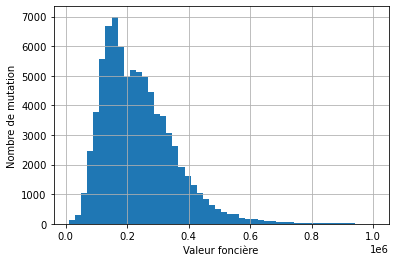

In [69]:
fig, ax = plt.subplots()
DATA_immo['valeur_fonciere'].hist(bins=50, ax=ax)
ax.set_xlabel('Valeur foncière')
ax.set_ylabel('Nombre de mutation')
plt.show()

#### code_departement

In [70]:
DATA_immo['code_departement'] = DATA_immo['code_departement'].astype(int)
DATA_immo.drop(DATA_immo[DATA_immo['code_departement'] != 91 ].index, inplace=True)

#### surface_carrez

lot #1
Surface minimum : 0.0
Surface maximum : 8062.0
Surface moyenne : 25.615745891198827
Surface mediane : 0.0
Nombre de valeurs manquantes : 50290


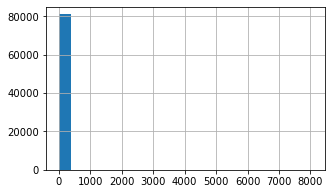

lot #2
Surface minimum : 0.0
Surface maximum : 7108.0
Surface moyenne : 5.74074929201239
Surface mediane : 0.0
Nombre de valeurs manquantes : 74361


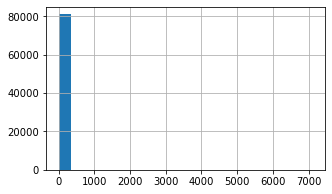

lot #3
Surface minimum : 0.0
Surface maximum : 369.02
Surface moyenne : 0.36418275354612134
Surface mediane : 0.0
Nombre de valeurs manquantes : 80451


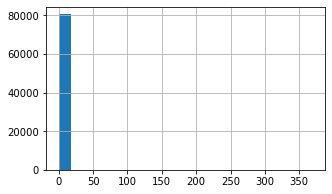

lot #4
Surface minimum : 0.0
Surface maximum : 440.76
Surface moyenne : 0.06298170980547348
Surface mediane : 0.0
Nombre de valeurs manquantes : 80801


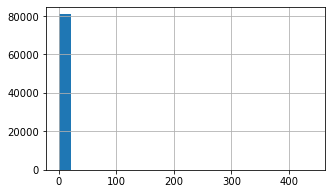

lot #5
Surface minimum : 0.0
Surface maximum : 250.0
Surface moyenne : 0.017848707072455876
Surface mediane : 0.0
Nombre de valeurs manquantes : 80847


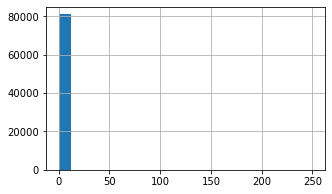

In [71]:
for n in range(1,6) :
    print("="*10)
    print(f"lot #{n}")
    print("="*10)
    print(f"Surface minimum : {DATA_immo[f'lot{n}_surface_carrez'].min()}")
    print(f"Surface maximum : {DATA_immo[f'lot{n}_surface_carrez'].max()}")
    print(f"Surface moyenne : {DATA_immo[f'lot{n}_surface_carrez'].mean()}")
    print(f"Surface mediane : {DATA_immo[f'lot{n}_surface_carrez'].median()}")
    print(f"Nombre de valeurs manquantes : {len(DATA_immo[DATA_immo[f'lot{n}_surface_carrez']==0])}")
    fig, ax = plt.subplots(figsize=(5,3))
    DATA_immo[f'lot{n}_surface_carrez'].hist(bins=20, ax=ax)
    plt.show()

La surface de chaque lot est peu renseignée, ce que provoque une majorité de nombre de lot à 0. Cette varaible ne semble pas assez fiable pour être prise en compte...

Il semble préférable de regrouper toutes les surfaces dans une seule variable.

In [72]:
col = [f'lot{n}_surface_carrez' for n in range(1,6)]
DATA_immo['surface_carrez'] = DATA_immo[col].sum(axis=1)

Surface minimum : 0.0
Surface maximum : 8062.0
Surface moyen : 31.801508353635178
Surface median : 0.0
Nombre de valeurs manquantes : 43659


<AxesSubplot:>

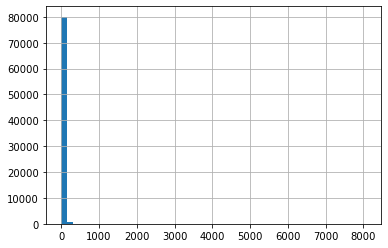

In [73]:
print(f"Surface minimum : {DATA_immo['surface_carrez'].min()}")
print(f"Surface maximum : {DATA_immo['surface_carrez'].max()}")
print(f"Surface moyen : {DATA_immo['surface_carrez'].mean()}")
print(f"Surface median : {DATA_immo['surface_carrez'].median()}")
print(f"Nombre de valeurs manquantes : {len(DATA_immo[DATA_immo['surface_carrez']==0])}")
DATA_immo['surface_carrez'].hist(bins=50)

In [74]:
print(f"Nombre de bien avec surface carrez inconnue : {len(DATA_immo[DATA_immo['surface_carrez'] == 0])}")

Nombre de bien avec surface carrez inconnue : 43659


Tout comme le nombre de lots, la surface carrez est peu renseignée.

In [75]:
DATA_immo.drop(col, axis="columns", inplace=True)

#### surface_reelle_bati

In [76]:
print(f"Surface réelle minimum : {DATA_immo['surface_reelle_bati'].min()}")
print(f"Surface réelle maximum : {DATA_immo['surface_reelle_bati'].max()}")
print(f"Surface réelle moyenne : {DATA_immo['surface_reelle_bati'].mean()}")
print(f"Surface réelle mediane : {DATA_immo['surface_reelle_bati'].median()}")
print(f"Nombre de valeurs manquantes : {len(DATA_immo[DATA_immo['surface_reelle_bati'] == 0])}")

Surface réelle minimum : 0.0
Surface réelle maximum : 803.0
Surface réelle moyenne : 77.31562024658992
Surface réelle mediane : 72.0
Nombre de valeurs manquantes : 2


In [77]:
DATA_immo.drop(DATA_immo[DATA_immo['surface_reelle_bati'] == 0].index, inplace=True)

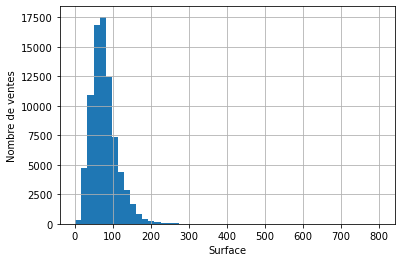

In [78]:
fig, ax = plt.subplots()
DATA_immo['surface_reelle_bati'].hist(bins=50, ax=ax)
ax.set_xlabel('Surface')
ax.set_ylabel("Nombre de ventes")
plt.show()

La surface réelle du batiment est beaucoup mieux renseignée que la surface de chaque lot.  
On supprime donc la surface carrez et le nombre de lot.

In [79]:
DATA_immo.drop(["surface_carrez"], axis="columns", inplace=True)

In [80]:
DATA_immo['surface_reelle_bati'].describe()

count    80861.000000
mean        77.317533
std         34.113835
min          1.000000
25%         55.000000
50%         72.000000
75%         94.000000
max        803.000000
Name: surface_reelle_bati, dtype: float64

Certains biens ont des surfaces inférieures à 10m2, ce qui semble peu probable : on les supprime

In [81]:
DATA_immo.drop(DATA_immo[DATA_immo['surface_reelle_bati']<10].index, inplace=True)

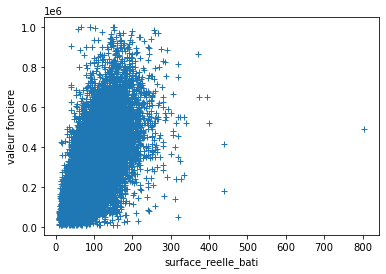

,surface_reelle_bati,valeur_fonciere
surface_reelle_bati,1.000000,0.711135
valeur_fonciere,0.711135,1.000000


In [82]:
fig, ax = plt.subplots()
ax.plot(DATA_immo['surface_reelle_bati'], DATA_immo['valeur_fonciere'], marker='+', linestyle='')
ax.set_xlabel('surface_reelle_bati')
ax.set_ylabel('valeur fonciere')
plt.show()
DATA_immo[['surface_reelle_bati', 'valeur_fonciere']].corr()

La valeur foncière et la surface sont très fortement corrélé

#### nombre_pieces_principales

Nombre de pièces minimum : 0.0
Nombre de pièces maximum : 109.0
Nombre de pièces moyen : 3.598238691882398
Nombre de pièces median : 4.0
Nombre de valeurs manquantes : 0
Nombre de valeurs à zero : 26


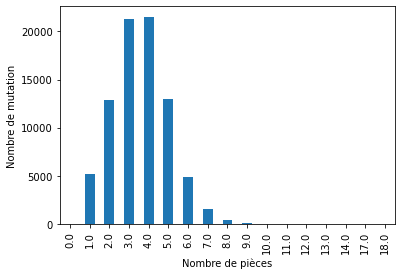

In [83]:
print(f"Nombre de pièces minimum : {DATA_immo['nombre_pieces_principales'].min()}")
print(f"Nombre de pièces maximum : {DATA_immo['nombre_pieces_principales'].max()}")
print(f"Nombre de pièces moyen : {DATA_immo['nombre_pieces_principales'].mean()}")
print(f"Nombre de pièces median : {DATA_immo['nombre_pieces_principales'].median()}")
print(f"Nombre de valeurs manquantes : {DATA_immo['nombre_pieces_principales'].isnull().sum()}")
print(f"Nombre de valeurs à zero : {len(DATA_immo[DATA_immo['nombre_pieces_principales']==0])}")
fig, ax = plt.subplots()
DATA_immo[DATA_immo['nombre_pieces_principales']<20]['nombre_pieces_principales'].value_counts().sort_index().plot(kind="bar")
ax.set_xlabel('Nombre de pièces')
ax.set_ylabel('Nombre de mutation')
plt.show()

On supprime les lignes dont le nombre de pièce est à 0 et celles dont le nombre de pièces est supérieur à 10.

In [84]:
DATA_immo.drop(DATA_immo[DATA_immo['nombre_pieces_principales']==0].index, inplace=True)
DATA_immo.drop(DATA_immo[DATA_immo['nombre_pieces_principales']>10].index, inplace=True)

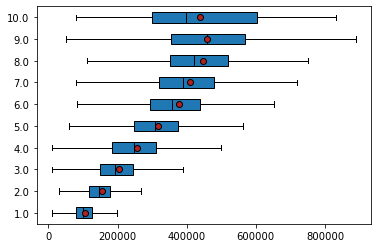

In [85]:
data = DATA_immo[pd.notnull(DATA_immo['nombre_pieces_principales'])]
data = data[pd.notnull(data['valeur_fonciere'])]
modalites = np.sort(data['nombre_pieces_principales'].unique())
groupes = []
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
             'markerfacecolor':'firebrick'}

for mod in modalites : 
    groupes.append(data[data['nombre_pieces_principales']==mod]['valeur_fonciere'])
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Comme attendu, la valeur foncière augmente avec le nombre de pièces.

#### surface_terrain

Surface terrain minimum : 0.0
Surface terrain maximim : 20937.0
Surface terrain moyen : 225.32043617640142
Surface terrain median : 0.0
Nombre de valeurs manquantes : 0
Nombre de valeurs à zero : 45998


<AxesSubplot:>

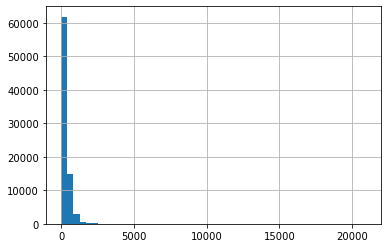

In [86]:
print(f"Surface terrain minimum : {DATA_immo['surface_terrain'].min()}")
print(f"Surface terrain maximim : {DATA_immo['surface_terrain'].max()}")
print(f"Surface terrain moyen : {DATA_immo['surface_terrain'].mean()}")
print(f"Surface terrain median : {DATA_immo['surface_terrain'].median()}")
print(f"Nombre de valeurs manquantes : {DATA_immo['surface_terrain'].isnull().sum()}")
print(f"Nombre de valeurs à zero : {len(DATA_immo[DATA_immo['surface_terrain']==0])}")
DATA_immo['surface_terrain'].hist(bins=50)

In [87]:
#DATA_immo.loc[DATA_immo['surface_terrain'].isnull().index, 'surface_terrain'] = 0

Les biens avec un terrain supérieur à 5000m2 ne sont pas correctement caractérisés, on les supprime.

In [88]:
DATA_immo.drop(DATA_immo[DATA_immo['surface_terrain']>5000].index, inplace=True)

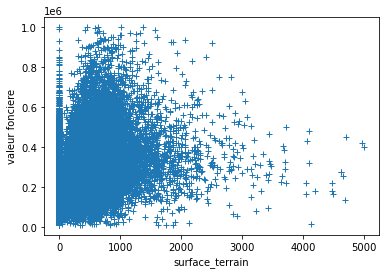

,surface_terrain,valeur_fonciere
surface_terrain,1.000000,0.543383
valeur_fonciere,0.543383,1.000000


In [89]:
fig, ax = plt.subplots()
ax.plot(DATA_immo['surface_terrain'], DATA_immo['valeur_fonciere'], marker='+', linestyle='')
ax.set_xlabel('surface_terrain')
ax.set_ylabel('valeur fonciere')
plt.show()
DATA_immo[['surface_terrain', 'valeur_fonciere']].corr()

#### nature_culture

In [90]:
DATA_immo['nature_culture'].value_counts(dropna=False)

sols                           27392
nan, nan                       26168
nan                            12772
nan, nan, nan                   7055
sols, sols                      4123
                               ...  
nan, terrains a bâtir, sols        1
futaies résineuses, sols           1
landes, sols, terres               1
terres, jardins, terres            1
terres, terres, nan                1
Name: nature_culture, Length: 166, dtype: int64

Une grande partie des valeurs ne sont pas renseignée, on préfère donc supprimer cette variable.

In [91]:
DATA_immo.drop('nature_culture', axis='columns', inplace=True)

#### nature_culture_speciale

In [92]:
DATA_immo['nature_culture_speciale'].value_counts(dropna=False)

nan                                                40339
nan, nan                                           31137
nan, nan, nan                                       8335
nan, Jardin potager                                  234
Jardin potager, nan                                  178
                                                   ...  
nan, Pré marais, nan                                   1
nan, Jardin potager, Parc                              1
nan, Sablière, nan                                     1
Verger exploite en basses tiges, Jardin potager        1
nan, nan, Etangs                                       1
Name: nature_culture_speciale, Length: 72, dtype: int64

Même chose que précédemment

In [93]:
DATA_immo.drop('nature_culture_speciale', axis='columns', inplace=True)

#### Localisation

Latitude minimum : 48.291626
Latitude maximum : 48.765597
Latitude moyenne : 48.638496597873285
Latitude médiane : 48.657185
Valeurs manquantes : 1074


<AxesSubplot:>

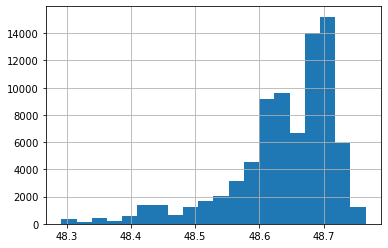

In [94]:
print(f"Latitude minimum : {DATA_immo['latitude'].min()}")
print(f"Latitude maximum : {DATA_immo['latitude'].max()}")
print(f"Latitude moyenne : {DATA_immo['latitude'].mean()}")
print(f"Latitude médiane : {DATA_immo['latitude'].median()}")
print(f"Valeurs manquantes : {DATA_immo['latitude'].isnull().sum()}")
DATA_immo["latitude"].hist(bins=20)

On supprime les observations dont les valeurs ne sont pas renseignées. (on pourrait essayer de localiser l'adresse si elle est disponible)  
La latitude doit être comprise entre 0 et 90, on supprime les autres valeurs

In [95]:
DATA_immo.drop(DATA_immo[DATA_immo['latitude']<0].index, inplace=True)
DATA_immo.drop(DATA_immo[DATA_immo['latitude']>90].index, inplace=True)

In [96]:
DATA_immo.drop(DATA_immo[DATA_immo['latitude'].isnull()].index, inplace=True)

Longitude minimum : 1.930095
Longitude maximum : 2.572263
Longitude moyenne : 2.3335218275106993
Longitude médiane : 2.34323
Valeurs manquantes : 0


<AxesSubplot:>

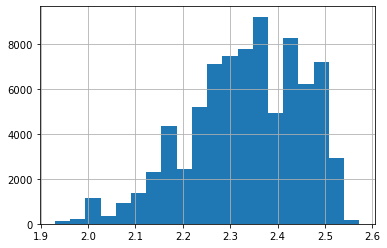

In [97]:
print(f"Longitude minimum : {DATA_immo['longitude'].min()}")
print(f"Longitude maximum : {DATA_immo['longitude'].max()}")
print(f"Longitude moyenne : {DATA_immo['longitude'].mean()}")
print(f"Longitude médiane : {DATA_immo['longitude'].median()}")
print(f"Valeurs manquantes : {DATA_immo['longitude'].isnull().sum()}")
DATA_immo["longitude"].hist(bins=20)

On supprime les observations dont les valeurs ne sont pas renseignées. (on pourrait essayer de localiser l'adresse si elle est disponible)  
La longitude doit être comprise entre -180 et +180, on supprime les autres valeurs

In [98]:
DATA_immo.drop(DATA_immo[DATA_immo['longitude']<-180].index, inplace=True)
DATA_immo.drop(DATA_immo[DATA_immo['longitude']>180].index, inplace=True)

In [99]:
DATA_immo.drop(DATA_immo[DATA_immo['longitude'].isnull()].index, inplace=True)

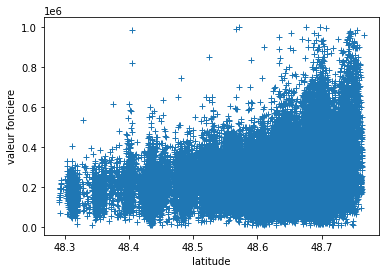

,latitude,valeur_fonciere
latitude,1.000000,0.183621
valeur_fonciere,0.183621,1.000000


In [100]:
fig, ax = plt.subplots()
ax.plot(DATA_immo['latitude'], DATA_immo['valeur_fonciere'], marker='+', linestyle='')
ax.set_xlabel('latitude')
ax.set_ylabel('valeur fonciere')
plt.show()
DATA_immo[['latitude', 'valeur_fonciere']].corr()

La latitude semble faiblement corrélé à la valeur foncière

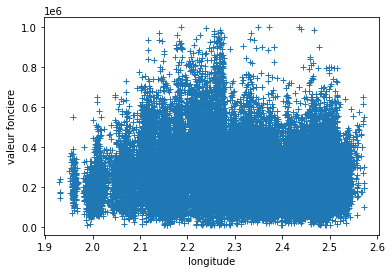

,longitude,valeur_fonciere
longitude,1.000000,-0.115662
valeur_fonciere,-0.115662,1.000000


In [101]:
fig, ax = plt.subplots()
ax.plot(DATA_immo['longitude'], DATA_immo['valeur_fonciere'], marker='+', linestyle='')
ax.set_xlabel('longitude')
ax.set_ylabel('valeur fonciere')
plt.show()
DATA_immo[['longitude', 'valeur_fonciere']].corr()

#### code_commune
Vérifier que chaque mutation contient des logements localisés sur une seule commune, sinon elles sont supprimées (trop éloignées).  
Vérifier que le code commune existe

In [102]:
DATA_immo.drop(DATA_immo[DATA_immo['code_commune'].str.split(', ').apply(set).apply(len) >1 ].index, inplace=True)

In [103]:
DATA_immo['code_commune'] = DATA_immo['code_commune'].str.split(', ').apply(set).apply(lambda x : list(x)[0])

In [104]:
DATA_immo[~DATA_immo['code_commune'].isin(DATA_com['CODGEO'])]

,id_mutation,surface_reelle_bati,date_mutation,valeur_fonciere,code_departement,nombre_lots,n_lignes,nombre_pieces_principales,surface_terrain,longitude,latitude,nature_mutation,code_commune,Dépendance,type_local,année,mois


In [105]:
DATA_immo.drop(DATA_immo[~DATA_immo['code_commune'].isin(DATA_com['CODGEO'])].index, inplace=True)

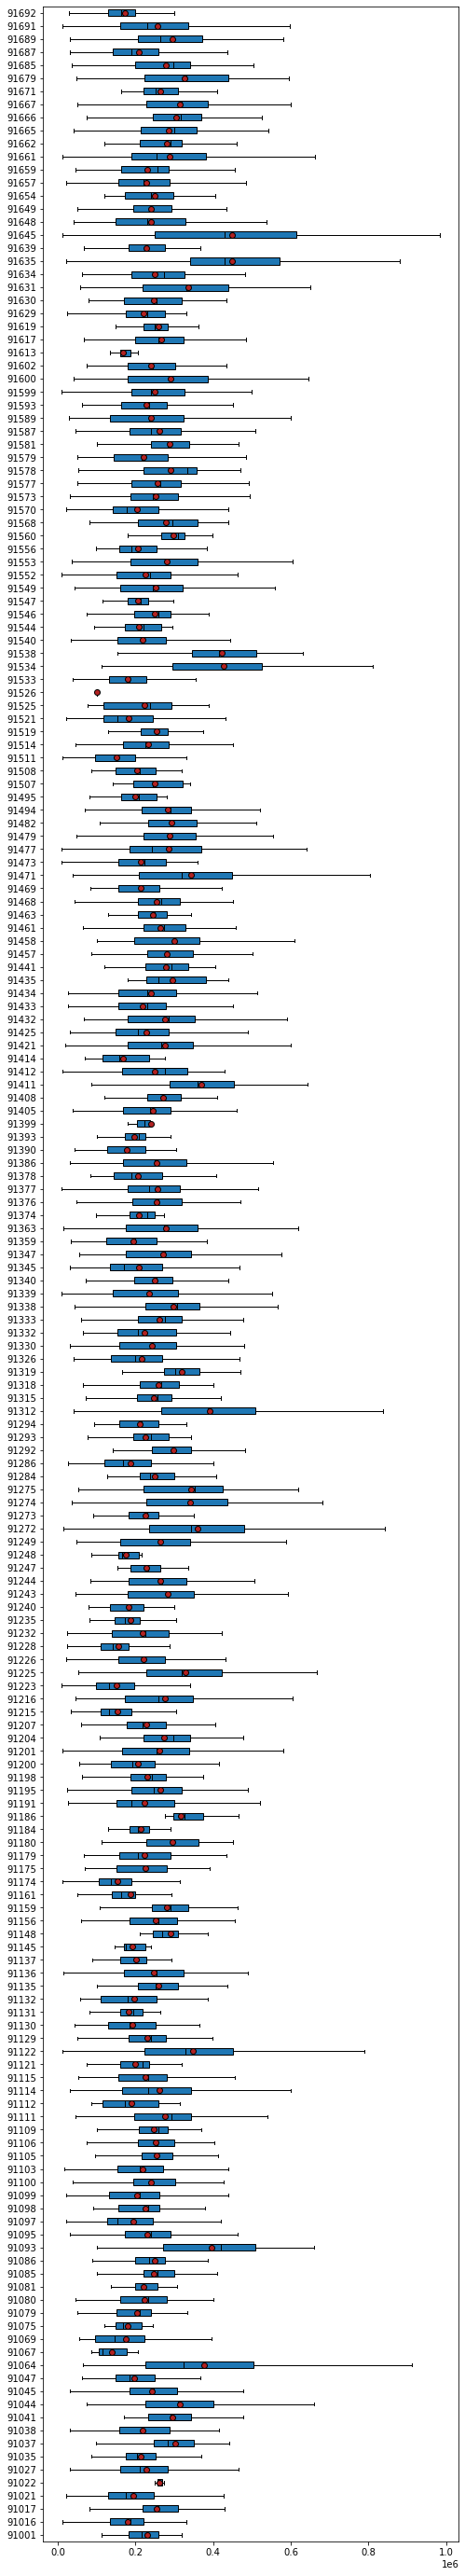

In [106]:
fig, ax = plt.subplots(figsize=(8,50))
data = DATA_immo[pd.notnull(DATA_immo['code_commune'])]
data = data[pd.notnull(data['valeur_fonciere'])]
modalites = np.sort(data['code_commune'].unique())
groupes = []
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
             'markerfacecolor':'firebrick'}

for mod in modalites : 
    groupes.append(data[data['code_commune']==mod]['valeur_fonciere'])
ax.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [107]:
def check_city(df, list_city=None) :
    if df['code_commune'] in list_city['CODGEO'].values :
        if df.nom_commune in list_city[list_city['CODGEO'] == df.code_commune]['LIBGEO'].values :
            return True
        else :
            print(f"{df.nom_commune} n'est pas le bon nom : {list_city[list_city['CODGEO'] == df.code_commune]['LIBGEO'].values}")
            return False
    else :
        print(f"{df.code_commune} n'est pas un code commune")
        return False

#### Résumé du néttoyage

In [108]:
print(f"Nombre de vente après nettoyage : {len(DATA_immo)}")
print(f"Nombre de variables après nettoyage : {len(DATA_immo.columns)}")
print(f"Variables : {', '.join(DATA_immo.columns)}")

Nombre de vente après nettoyage : 79593
Nombre de variables après nettoyage : 17
Variables : id_mutation, surface_reelle_bati, date_mutation, valeur_fonciere, code_departement, nombre_lots, n_lignes, nombre_pieces_principales, surface_terrain, longitude, latitude, nature_mutation, code_commune, Dépendance, type_local, année, mois


#### Sauvegarde

In [109]:
DATA_immo.to_csv("database_ventes_immo_cleaned.csv", sep=',',index=False)

### Données éducations

#### Variables disponibles 

In [110]:
DATA_ecole.columns

Index(['Code établissement', 'Appellation officielle',
       'Dénomination principale', 'Patronyme uai', 'Secteur Public/Privé',
       'Adresse', 'Lieu dit', 'Boite postale', 'Code postal',
       'Localite d'acheminement', 'Commune', 'Coordonnee X', 'Coordonnee Y',
       'EPSG', 'Latitude', 'Longitude', 'Qualité d'appariement',
       'Localisation', 'Code nature', 'Nature', 'Code état établissement',
       'Etat établissement', 'Code département', 'Code région',
       'Code académie', 'Code commune', 'Département', 'Région', 'Académie',
       'Position', 'secteur_prive_code_type_contrat',
       'secteur_prive_libelle_type_contrat', 'code_ministere',
       'libelle_ministere', 'date_ouverture'],
      dtype='object')

In [111]:
DATA_ecole.head()

,Code établissement,Appellation officielle,Dénomination principale,Patronyme uai,Secteur Public/Privé,Adresse,Lieu dit,Boite postale,Code postal,Localite d'acheminement,Commune,Coordonnee X,Coordonnee Y,EPSG,Latitude,Longitude,Qualité d'appariement,Localisation,Code nature,Nature,Code état établissement,Etat établissement,Code département,Code région,Code académie,Code commune,Département,Région,Académie,Position,secteur_prive_code_type_contrat,secteur_prive_libelle_type_contrat,code_ministere,libelle_ministere,date_ouverture
0,0133931C,Lycée Général Privé Notre Dame De La Viste,LYCEE GENERAL PRIVE,NOTRE DAME DE LA VISTE,Privé,111 chemin HENRI BEYLE,NaN,12,13314,MARSEILLE CEDEX 15,Marseille 15e Arrondissement,891349.7,6253229.9,EPSG:2154,43.352481,5.359270,Correcte,Numéro de rue,302,LYCEE D ENSEIGNEMENT GENERAL,1,OUVERT,013,93,2,13215,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Aix-Marseille,"43.35248128251459,5.359269984052946",30.0,CONTRAT D'ASSOCIATION TOUTES CLASSES,6,MINISTERE DE L'EDUCATION NATIONALE,2008-09-01
1,0134431W,collège de lançon-Provence,COLLEGE,COLLEGE DE LANCON-PROVENCE,Public,Allée de la Croix de Pélissanne,NaN,NaN,13680,LANCON PROVENCE,Lançon-Provence,872003.2,6280077.8,EPSG:2154,43.598877,5.129783,Correcte,Rue,340,COLLEGE,1,OUVERT,013,93,2,13051,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,Aix-Marseille,"43.59887721243803,5.129782827341684",99.0,SANS OBJET,6,MINISTERE DE L'EDUCATION NATIONALE,2021-10-19
2,0150225N,Ecole élémentaire,ECOLE ELEMENTAIRE PUBLIQUE,NaN,Public,4 rue des Ecoles,NaN,NaN,15190,LUGARDE,Lugarde,681228.4,6465391.2,EPSG:2154,45.287624,2.760550,Mauvaise,Numéro de rue,151,ECOLE DE NIVEAU ELEMENTAIRE,1,OUVERT,015,84,6,15110,Cantal,Auvergne-Rhône-Alpes,Clermont-Ferrand,"45.287623852267366,2.760550173244711",99.0,SANS OBJET,6,MINISTERE DE L'EDUCATION NATIONALE,1968-10-06
3,0230568T,Ecole primaire,ECOLE PRIMAIRE PUBLIQUE,NaN,Public,11 rue des Ecoles,NaN,NaN,23320,BUSSIERE DUNOISE,Bussière-Dunoise,604573.8,6574226.0,EPSG:2154,46.261173,1.761060,Parfaite,Numéro de rue,151,ECOLE DE NIVEAU ELEMENTAIRE,1,OUVERT,023,75,22,23036,Creuse,Nouvelle-Aquitaine,Limoges,"46.26117276936779,1.7610604228533016",99.0,SANS OBJET,6,MINISTERE DE L'EDUCATION NATIONALE,1991-09-09
4,0341600E,Ecole primaire François Mitterand,ECOLE PRIMAIRE,FRANCOIS MITTERRAND,Public,Avenue des Platanes,NaN,NaN,34310,MONTADY,Montady,709945.3,6248094.0,EPSG:2154,43.331927,3.122560,Parfaite,Numéro de rue,151,ECOLE DE NIVEAU ELEMENTAIRE,1,OUVERT,034,76,11,34161,Hérault,Occitanie,Montpellier,"43.33192735511708,3.122559903938699",99.0,SANS OBJET,6,MINISTERE DE L'EDUCATION NATIONALE,1984-09-01


In [112]:
DATA_ecole.describe()

,Code postal,Coordonnee X,Coordonnee Y,Latitude,Longitude,Code nature,Code état établissement,Code région,Code académie,secteur_prive_code_type_contrat,code_ministere
count,65526.000000,6.476500e+04,6.476500e+04,64763.000000,64763.000000,65526.000000,65526.000000,65526.000000,65526.000000,65519.000000,65526.000000
mean,54514.519458,6.673481e+05,6.595600e+06,45.436032,2.357495,183.573803,1.009553,48.661615,14.446067,87.583953,5.981946
std,27608.313042,2.053775e+05,7.458918e+05,9.561746,10.645613,86.684172,0.112413,28.700128,8.217567,26.810281,1.178943
min,1000.000000,1.234000e+03,1.234000e+03,-21.387619,-63.106640,101.000000,1.000000,0.000000,1.000000,10.000000,0.000000
25%,31650.000000,5.286853e+05,6.451750e+06,44.931591,0.804865,151.000000,1.000000,27.000000,8.000000,99.000000,6.000000
50%,59100.000000,6.589771e+05,6.724924e+06,47.431742,2.465760,151.000000,1.000000,44.000000,14.000000,99.000000,6.000000
75%,77164.750000,8.328466e+05,6.866075e+06,48.860881,4.823490,151.000000,1.000000,76.000000,20.000000,99.000000,6.000000
max,98890.000000,1.240349e+06,8.598038e+06,51.071190,55.825940,390.000000,3.000000,94.000000,44.000000,99.000000,80.000000


#### Suppression des écoles hors département
Les départements ne sont pas renseignés. De ce fait le département sera déterminé à partir du code postal.  
Le code postal est codé en int, il faut tenir compte que le premier 0 peut être supprimé.

In [113]:
DATA_ecole['Code postal'] = DATA_ecole['Code postal'].astype(str).apply(lambda x : x if (len(x) == 5) else "0"+x)
DATA_ecole['code_departement'] = DATA_ecole['Code postal'].apply(lambda x : x[:2])
DATA_ecole = DATA_ecole[DATA_ecole['code_departement']=="91"]
print(f"Nombre d'école dans le département : {len(DATA_ecole)}")

Nombre d'école dans le département : 1104


#### Variables conservées
Parmis les variables disponibles, seules les variables suivantes seront conservées :
- 'Secteur Public/Privé'
- 'Code postal'
- 'Commune'
- 'Latitude', 'Longitude'
- 'Nature'
- 'Etat établissement'
- 'code_departement'

In [114]:
variables = ['Secteur Public/Privé', 'Code postal', 'Commune', 'Latitude', 'Longitude',\
            'Nature', 'Etat établissement', 'code_departement']
DATA_ecole = DATA_ecole[variables]

#### Etat établissement

In [115]:
DATA_ecole['Etat établissement'].value_counts()

OUVERT      1103
A FERMER       1
Name: Etat établissement, dtype: int64

On supprime les établissements fermés.

In [116]:
DATA_ecole.drop(DATA_ecole[DATA_ecole['Etat établissement'] != "OUVERT"].index, inplace=True)

La variable ne sera plus utilisés, on la supprime:

In [117]:
DATA_ecole.drop('Etat établissement', axis="columns", inplace=True)

#### Nature
Le nombre de nature des établissements est trop grand, on va les simplifier par commodité.  
- école maternelle
- école élémentaire
- collège
- lycée
Les maisons familiale rurale sont très spécifique et peu nombreuse : on les supprime. 

In [118]:
DATA_ecole['Nature'].value_counts(dropna=False)

ECOLE DE NIVEAU ELEMENTAIRE                 481
ECOLE MATERNELLE                            375
COLLEGE                                     129
LYCEE ENSEIGNT GENERAL ET TECHNOLOGIQUE      26
SECTION ENSEIGNT GEN. ET PROF. ADAPTE        26
LYCEE POLYVALENT                             23
SECTION D ENSEIGNEMENT PROFESSIONNEL         15
LYCEE PROFESSIONNEL                          14
ECOLE ELEMENTAIRE D APPLICATION               4
LYCEE D ENSEIGNEMENT GENERAL                  3
ECOLE MATERNELLE D APPLICATION                3
ETAB REGIONAL/LYCEE ENSEIGNEMENT ADAPTE       2
MAISON FAMILIALE RURALE EDUCATION ORIENT      2
Name: Nature, dtype: int64

In [119]:
DATA_ecole.drop(DATA_ecole[DATA_ecole['Nature'] == 'MAISON FAMILIALE RURALE EDUCATION ORIENT'].index, inplace=True)

In [120]:
nom_ecole = pd.DataFrame({"Nature" : ['ECOLE DE NIVEAU ELEMENTAIRE', 'ECOLE MATERNELLE', 'COLLEGE', \
                          'LYCEE ENSEIGNT GENERAL ET TECHNOLOGIQUE', 'SECTION ENSEIGNT GEN. ET PROF. ADAPTE', \
                          'LYCEE POLYVALENT', 'SECTION D ENSEIGNEMENT PROFESSIONNEL', 'LYCEE PROFESSIONNEL',\
                         'ECOLE ELEMENTAIRE D APPLICATION', 'LYCEE D ENSEIGNEMENT GENERAL', 'ECOLE MATERNELLE D APPLICATION',\
                         'ETAB REGIONAL/LYCEE ENSEIGNEMENT ADAPTE'], \
              "niveau" : ['ecole_elementaire', 'ecole_maternelle', 'college', \
                          'lycee', 'lycee', \
                          'lycee', 'lycee', 'lycee',\
                         'ecole_elementaire', 'lycee', 'ecole_maternelle',\
                         'lycee']})
nom_ecole

,Nature,niveau
0,ECOLE DE NIVEAU ELEMENTAIRE,ecole_elementaire
1,ECOLE MATERNELLE,ecole_maternelle
2,COLLEGE,college
3,LYCEE ENSEIGNT GENERAL ET TECHNOLOGIQUE,lycee
4,SECTION ENSEIGNT GEN. ET PROF. ADAPTE,lycee
5,LYCEE POLYVALENT,lycee
6,SECTION D ENSEIGNEMENT PROFESSIONNEL,lycee
7,LYCEE PROFESSIONNEL,lycee
8,ECOLE ELEMENTAIRE D APPLICATION,ecole_elementaire
9,LYCEE D ENSEIGNEMENT GENERAL,lycee


In [121]:
DATA_ecole = pd.merge(DATA_ecole, nom_ecole, how='left', on='Nature')

<AxesSubplot:ylabel='niveau'>

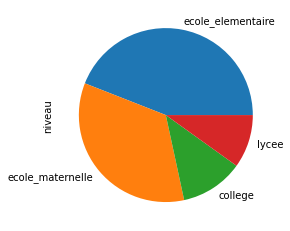

In [122]:
DATA_ecole['niveau'].value_counts(dropna=False).plot.pie()

In [123]:
DATA_ecole.drop("Nature", axis="columns", inplace=True)

#### Localisation

Latitude minimum : 43.4135566222618
Latitude maximum : 49.47417063554631
Latitude moyenne : 48.6204315243241
Latitude médiane : 48.64988396643415
Valeurs manquantes : 1


<AxesSubplot:>

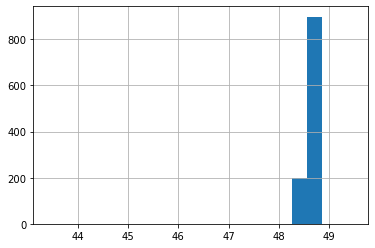

In [124]:
print(f"Latitude minimum : {DATA_ecole['Latitude'].min()}")
print(f"Latitude maximum : {DATA_ecole['Latitude'].max()}")
print(f"Latitude moyenne : {DATA_ecole['Latitude'].mean()}")
print(f"Latitude médiane : {DATA_ecole['Latitude'].median()}")
print(f"Valeurs manquantes : {DATA_ecole['Latitude'].isnull().sum()}")
DATA_ecole["Latitude"].hist(bins=20)

On supprime les valeurs manquantes et on vérifie que la Latitue est comprise entre 0 et 90.

In [125]:
DATA_ecole.drop(DATA_ecole[DATA_ecole['Latitude'].isnull()].index, inplace=True)

In [126]:
DATA_ecole.drop(DATA_ecole[DATA_ecole['Latitude']<0].index, inplace=True)
DATA_ecole.drop(DATA_ecole[DATA_ecole['Latitude']>90].index, inplace=True)

Longitude minimum : -1.1455965742054517
Longitude maximum : 6.0628501840133255
Longitude moyenne : 2.3171718226817806
Longitude médiane : 2.334135298194837
Valeurs manquantes : 0


<AxesSubplot:>

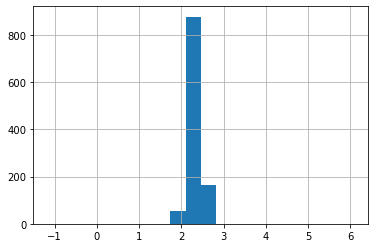

In [127]:
print(f"Longitude minimum : {DATA_ecole['Longitude'].min()}")
print(f"Longitude maximum : {DATA_ecole['Longitude'].max()}")
print(f"Longitude moyenne : {DATA_ecole['Longitude'].mean()}")
print(f"Longitude médiane : {DATA_ecole['Longitude'].median()}")
print(f"Valeurs manquantes : {DATA_ecole['Longitude'].isnull().sum()}")
DATA_ecole["Longitude"].hist(bins=20)

In [128]:
DATA_ecole.drop(DATA_ecole[DATA_ecole['Longitude'].isnull()].index, inplace=True)
DATA_ecole.drop(DATA_ecole[DATA_ecole['Longitude']<-180].index, inplace=True)
DATA_ecole.drop(DATA_ecole[DATA_ecole['Longitude']>180].index, inplace=True)

##### Sauvegarde

In [129]:
DATA_ecole.to_csv("database_ecoles.csv", sep=',',index=False)

#### Universités

##### Variables disponibles

In [130]:
print(f"Nombre de variables : {len(DATA_univ.columns)}")
print(f"Liste des variables : {', '.join(DATA_univ.columns)}")

Nombre de variables : 117
Liste des variables : uo_lib, nom_court, sigle, type_d_etablissement, typologie_d_universites_et_assimiles, secteur_d_etablissement, vague_contractuelle, localisation, url, coordonnees, uai, siret, siren, rna, identifiant_wikidata, element_wikidata, identifiant_idref, identifiant_eter, identifiant_ror, element_ror, identifiant_grid, element_grid, identifiant_orgref, identifiant_isni, element_isni, identifiant_funding_data, element_fundref, identifiant_dataesr, anciens_codes_uai, rattachement_identifiants, rattachement, association_identifiants, association, date_creation, texte_de_ref_creation_lib, texte_de_ref_creation, date_fermeture, texte_de_ref_fermeture_lib, texte_de_ref_fermeture, dernier_decret_legifrance_lib, dernier_decret_legifrance, com_code, com_nom, uucr_id, uucr_nom, dep_id, dep_nom, aca_id, aca_nom, reg_id, reg_nom, reg_id_old, reg_nom_old, mention_distribution, adresse_uai, lieu_dit_uai, boite_postale_uai, code_postal_uai, localite_acheminemen

In [131]:
DATA_univ.head()

,uo_lib,nom_court,sigle,type_d_etablissement,typologie_d_universites_et_assimiles,secteur_d_etablissement,vague_contractuelle,localisation,url,coordonnees,uai,siret,siren,rna,identifiant_wikidata,element_wikidata,identifiant_idref,identifiant_eter,identifiant_ror,element_ror,identifiant_grid,element_grid,identifiant_orgref,identifiant_isni,element_isni,identifiant_funding_data,element_fundref,identifiant_dataesr,anciens_codes_uai,rattachement_identifiants,rattachement,association_identifiants,association,date_creation,texte_de_ref_creation_lib,texte_de_ref_creation,date_fermeture,texte_de_ref_fermeture_lib,texte_de_ref_fermeture,dernier_decret_legifrance_lib,dernier_decret_legifrance,com_code,com_nom,uucr_id,uucr_nom,dep_id,dep_nom,aca_id,aca_nom,reg_id,reg_nom,reg_id_old,reg_nom_old,mention_distribution,adresse_uai,lieu_dit_uai,boite_postale_uai,code_postal_uai,localite_acheminement_uai,pays_etranger_acheminement,numero_telephone_uai,statut_juridique_court,statut_juridique_long,qualification_court,qualification_long,compte_facebook,compte_twitter,compte_instagram,compte_flickr,compte_pinterest,flux_rss,compte_linkedin,compte_viadeo,compte_france_culture,compte_scribd,compte_scoopit,compte_tumblr,compte_youtube,compte_vimeo,compte_dailymotion,autres,compte_github,wikipedia,wikipedia_en,scanr,hal,mooc,article,uo_lib_officiel,uo_lib_en,url_en,url_cn,url_es,url_de,url_it,inscrits_2010,inscrits_2011,inscrits_2012,inscrits_2013,inscrits_2014,inscrits_2015,inscrits_2016,inscrits_2017,uai_rgp_loi_esr_2013,universites_fusionnees,etablissement_experimental,implantations,identifiant_programmes_lolf,statut_operateur_lolf,libelle_missions_lolf,libelle_programmes_lolf,libelle_programme_lolf_chef_de_file,identifiants_autres_programmes_lolf,libelles_autres_programmes_lolf,identifiant_programme_lolf_chef_de_file,libelle_mission_chef_de_file,compte_googleplus
0,École supérieure de chimie organique et minérale,NaN,ESCOM,École,NaN,Privé,Vague E,Hauts-de-France>Amiens>Oise>Compiègne,https://www.escom.fr/,"49.40196,2.80246",0602099F,7.842808e+13,784280760.0,NaN,Q3578426,https://www.wikidata.org/entity/Q3578426,NaN,FR0131,02j530k95,https://ror.org/02j530k95,grid.466358.a,NaN,NaN,0000 0001 0225 2269,http://www.isni.org/0000000102252269,NaN,NaN,NaN,0602099F;0951803U,NaN,NaN,NaN,NaN,1969.0,NaN,NaN,NaN,NaN,NaN,Arrêté du 7 décembre 2021 fixant la liste des ...,https://www.legifrance.gouv.fr/jorf/id/JORFTEX...,60159,Compiègne,UU60502,Compiègne,D060,Oise,A20,Amiens,R32,Hauts-de-France,R22,Picardie,NaN,1 allée du Réseau Jean-Marie Buckmaster,NaN,NaN,60200.0,Compiègne,France,344238800.0,Association loi de 1901,Association loi de 1901,EESPIG,Établissement d’enseignement supérieur privé d...,https://www.facebook.com/Escom-Chimie-Page-Off...,https://twitter.com/escom_chimie,https://www.instagram.com/escom_chimie_compieg...,NaN,NaN,https://www.escom.fr/feed/,https://www.linkedin.com/school/escom-chimie-c...,NaN,NaN,NaN,NaN,NaN,https://www.youtube.com/user/escomchimie,NaN,NaN,NaN,NaN,https://fr.wikipedia.org/wiki/%C3%89cole_sup%C...,https://en.wikipedia.org/wiki/%C3%89cole_sup%C...,https://scanr.enseignementsup-recherche.gouv.f...,NaN,NaN,à l',École supérieure de chimie organique et minérale,NaN,https://www.escom.fr/international/welcome-at-...,NaN,NaN,NaN,NaN,564,555,603,623,628,593,574,556,dataesr::AE03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,École supérieure des sciences économiques et c...,NaN,Essec,École,NaN,Privé,Vague E,Île-de-France>Versailles>Val-d'Oise>Cergy,https://www.essec.edu/fr/,"49.03397,2.078427",0951214D,7.756640e+13,775663958.0,W953002511,Q273642,https://www.wikidata.org/entity/Q273642,028029429,NaN,02dga6j42,https://ror.org/02dga6j42,grid.432649.e,NaN,510007.0,0000 0001 0666 5255,http://www.isni.org/0000000106665255,NaN,NaN,NaN,0951214D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Décret n° 2020-1478 du 30 novembre 2020 portan...,https://www.legifrance.gouv.fr/jorf/id/JORFTEX...,95127,Cergy,UU00851,Paris,D095,Val-d'Oise,A25,Versaille

In [132]:
DATA_univ.describe()

,siret,siren,identifiant_orgref,identifiant_funding_data,element_fundref,rattachement_identifiants,rattachement,association_identifiants,association,date_creation,date_fermeture,code_postal_uai,numero_telephone_uai,compte_viadeo,autres,url_it,implantations,identifiant_programmes_lolf,statut_operateur_lolf,libelle_missions_lolf,libelle_programmes_lolf,libelle_programme_lolf_chef_de_file,identifiants_autres_programmes_lolf,libelles_autres_programmes_lolf,identifiant_programme_lolf_chef_de_file,libelle_mission_chef_de_file,compte_googleplus
count,2.520000e+02,2.520000e+02,1.160000e+02,0.0,2.000000e+01,0.0,0.0,0.0,0.0,214.000000,2.000000,254.000000,1.740000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3.200457e+13,3.200457e+08,1.241403e+07,NaN,4.510000e+11,NaN,NaN,NaN,NaN,1956.602804,2020.500000,61013.074803,3.131499e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.330443e+13,2.330443e+08,1.158519e+07,NaN,1.542045e+11,NaN,NaN,NaN,NaN,72.921826,0.707107,25468.278091,1.485970e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.300004e+13,1.300004e+08,6.844700e+04,NaN,1.000090e+08,NaN,NaN,NaN,NaN,1431.000000,2020.000000,186.000000,1.307362e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.928039e+13,1.928039e+08,3.202086e+06,NaN,5.011000e+11,NaN,NaN,NaN,NaN,1948.000000,2020.250000,35170.000000,1.615812e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.975348e+13,1.975348e+08,1.037183e+07,NaN,5.011000e+11,NaN,NaN,NaN,NaN,1971.000000,2020.500000,69300.500000,2.985394e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.849972e+13,3.849972e+08,1.395822e+07,NaN,5.011000e+11,NaN,NaN,NaN,NaN,1994.000000,2020.750000,77184.000000,4.712008e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.981921e+13,8.981921e+08,4.700244e+07,NaN,5.011000e+11,NaN,NaN,NaN,NaN,2021.000000,2021.000000,98851.000000,5.942979e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Variables conservées
Il y a un grand nombre de variables, on ne conserve que quelques unes utiles pour la suite :
- uo_lib : Nom de l'établissement
- type_d_etablissement
- secteur_d_etablissement : public / privé
- coordonnees : localisation
- com_code : code commune
- com_nom : nom commune
- code_postal_uai : code postal
- inscrits_2010, inscrits_2011, inscrits_2012, inscrits_2013, inscrits_2014, inscrits_2015, inscrits_2016, inscrits_2017 : nb d'inscrits 

In [133]:
variables = ['uo_lib', 'type_d_etablissement', 'secteur_d_etablissement', 'coordonnees', 'com_code', 'com_nom', \
             'code_postal_uai']+ [f"inscrits_{an}" for an in range(2010, 2018)]
DATA_univ = DATA_univ[variables]

##### type d'établissement

In [134]:
DATA_univ['type_d_etablissement'].value_counts(dropna=False)

École                  153
Université              67
Grand établissement     23
Autre établissement     12
Name: type_d_etablissement, dtype: int64

In [135]:
DATA_univ.drop(DATA_univ[DATA_univ['type_d_etablissement'].isnull()].index, inplace=True)

<AxesSubplot:ylabel='type_d_etablissement'>

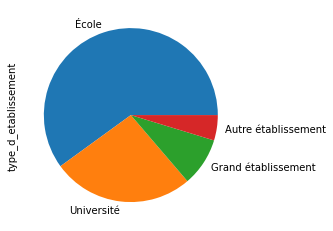

In [136]:
DATA_univ['type_d_etablissement'].value_counts(dropna=False).plot.pie()

##### secteur_d_etablissement

In [137]:
DATA_univ['secteur_d_etablissement'].value_counts(dropna=False)

Public    168
Privé      85
NaN         2
Name: secteur_d_etablissement, dtype: int64

In [138]:
DATA_univ.drop(DATA_univ[DATA_univ['secteur_d_etablissement'].isnull()].index, inplace=True)

<AxesSubplot:ylabel='secteur_d_etablissement'>

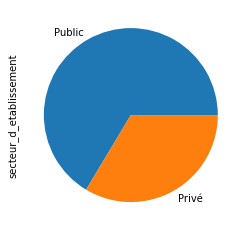

In [139]:
DATA_univ['secteur_d_etablissement'].value_counts(dropna=False).plot.pie()

##### coordonnees

In [140]:
tmp = DATA_univ['coordonnees'].str.split(',', expand=True).values
DATA_univ['latitude'] = tmp[:,0]
DATA_univ['longitude'] = tmp[:,1]
DATA_univ['latitude'] = DATA_univ['latitude'].astype(float)
DATA_univ['longitude'] = DATA_univ['longitude'].astype(float)

In [141]:
DATA_univ.drop(DATA_univ[DATA_univ['latitude'].isnull()].index, inplace=True)
DATA_univ.drop(DATA_univ[DATA_univ['latitude']<0].index, inplace=True)
DATA_univ.drop(DATA_univ[DATA_univ['latitude']>90].index, inplace=True)

Latitude minimum : 4.93174
Latitude maximum : 51.039
Latitude moyenne : 47.11083473501888
Latitude médiane : 48.582371
Valeurs manquantes : 0


<AxesSubplot:>

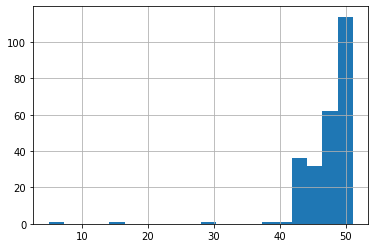

In [142]:
print(f"Latitude minimum : {DATA_univ['latitude'].min()}")
print(f"Latitude maximum : {DATA_univ['latitude'].max()}")
print(f"Latitude moyenne : {DATA_univ['latitude'].mean()}")
print(f"Latitude médiane : {DATA_univ['latitude'].median()}")
print(f"Valeurs manquantes : {DATA_univ['latitude'].isnull().sum()}")
DATA_univ["latitude"].hist(bins=20)

In [143]:
DATA_univ.drop(DATA_univ[DATA_univ['longitude'].isnull()].index, inplace=True)
DATA_univ.drop(DATA_univ[DATA_univ['longitude']<-180].index, inplace=True)
DATA_univ.drop(DATA_univ[DATA_univ['longitude']>180].index, inplace=True)

longitude minimum : -61.53016
longitude maximum : 31.2352879
longitude moyenne : 1.9073061074251405
longitude médiane : 2.32936
Valeurs manquantes : 0


<AxesSubplot:>

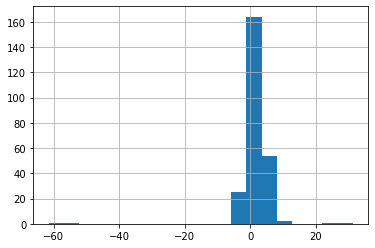

In [144]:
print(f"longitude minimum : {DATA_univ['longitude'].min()}")
print(f"longitude maximum : {DATA_univ['longitude'].max()}")
print(f"longitude moyenne : {DATA_univ['longitude'].mean()}")
print(f"longitude médiane : {DATA_univ['longitude'].median()}")
print(f"Valeurs manquantes : {DATA_univ['longitude'].isnull().sum()}")
DATA_univ["longitude"].hist(bins=20)

In [145]:
DATA_univ.drop('coordonnees', axis='columns', inplace=True)

##### code postal

In [146]:
DATA_univ['code_postal_uai'] = DATA_univ['code_postal_uai'].astype(int).astype(str)

##### nombre inscrits

In [147]:
for an in range(2010, 2018) :
    DATA_univ[f'inscrits_{an}'] = DATA_univ[f'inscrits_{an}'].astype(str)
    DATA_univ[f'inscrits_{an}']= DATA_univ[f'inscrits_{an}'].apply(lambda x : x.replace(' ', ''))
    DATA_univ[f'inscrits_{an}'] = DATA_univ[f'inscrits_{an}'].apply(lambda x : int(x) if x.isdigit() else np.NaN)
    print("="*20)
    print(an)
    print("="*20)
    print(f"Nombre d'inscrits minimum : {DATA_univ[f'inscrits_{an}'].min()}")
    print(f"Nombre d'inscrits maximum : {DATA_univ[f'inscrits_{an}'].max()}")
    print(f"Nombre d'inscrits moyen : {DATA_univ[f'inscrits_{an}'].mean()}")    
    print(f"Nombre d'inscrits median : {DATA_univ[f'inscrits_{an}'].median()}")
    print(f"Nombre de valeurs manquantes : {DATA_univ[f'inscrits_{an}'].isnull().sum()}")

2010
Nombre d'inscrits minimum : 57.0
Nombre d'inscrits maximum : 63641.0
Nombre d'inscrits moyen : 7936.187096774193
Nombre d'inscrits median : 2309.0
Nombre de valeurs manquantes : 94
2011
Nombre d'inscrits minimum : 66.0
Nombre d'inscrits maximum : 62905.0
Nombre d'inscrits moyen : 8018.00641025641
Nombre d'inscrits median : 2358.5
Nombre de valeurs manquantes : 93
2012
Nombre d'inscrits minimum : 67.0
Nombre d'inscrits maximum : 60648.0
Nombre d'inscrits moyen : 8084.535031847134
Nombre d'inscrits median : 2508.0
Nombre de valeurs manquantes : 92
2013
Nombre d'inscrits minimum : 79.0
Nombre d'inscrits maximum : 59158.0
Nombre d'inscrits moyen : 8135.683544303797
Nombre d'inscrits median : 2526.0
Nombre de valeurs manquantes : 91
2014
Nombre d'inscrits minimum : 82.0
Nombre d'inscrits maximum : 60154.0
Nombre d'inscrits moyen : 8155.54375
Nombre d'inscrits median : 2631.5
Nombre de valeurs manquantes : 89
2015
Nombre d'inscrits minimum : 80.0
Nombre d'inscrits maximum : 62648.0
Nomb

In [148]:
DATA_univ['inscrits_moyen'] = DATA_univ[[f"inscrits_{an}" for an in range(2010, 2018)]].mean(axis=1)

In [149]:
DATA_univ.drop([f"inscrits_{an}" for an in range(2010, 2018)], axis='columns', inplace=True)

##### Sauvegarde

In [150]:
DATA_univ.to_csv("database_universites_cleaned.csv", sep=',',index=False)

### Données loyers
#### Appartement

In [12]:
print(f"Nombre de variables disponobles : {len(DATA_appart.columns)}")
print(f"Liste des variables : {', '.join(DATA_appart.columns)}")

Nombre de variables disponobles : 13
Liste des variables : id_zone, INSEE, LIBGEO, DEP, REG, EPCI, TYPPRED, loypredm2, lwr.IPm2, upr.IPm2, R2adj, NBobs_maille, NBobs_commune


In [13]:
DATA_appart.head()

,id_zone,INSEE,LIBGEO,DEP,REG,EPCI,TYPPRED,loypredm2,lwr.IPm2,upr.IPm2,R2adj,NBobs_maille,NBobs_commune
0,2362,1001,L'Abergement-Clémenciat,1,84,200069193,maille,"9,372335348","7,409663525","11,85487972","0,774249278",701,2
1,2010,1002,L'Abergement-de-Varey,1,84,240100883,maille,"8,63555202","6,72107751","11,09535764","0,719598662",861,0
2,1456,1004,Ambérieu-en-Bugey,1,84,240100883,commune,"10,07450708","7,865307059","12,90422511","0,670160882",2156,2156
3,2362,1005,Ambérieux-en-Dombes,1,84,200042497,maille,"9,372335348","7,409663525","11,85487972","0,774249278",701,81
4,2055,1006,Ambléon,1,84,200040350,maille,"8,96695486","7,101593346","11,3222872","0,752823051",842,3


In [14]:
DATA_appart.describe()

,REG,NBobs_maille,NBobs_commune
count,35441.000000,35441.000000,35441.000000
mean,52.332186,1054.792782,204.381959
std,24.334885,2298.805930,2315.567062
min,1.000000,467.000000,0.000000
25%,28.000000,655.000000,0.000000
50%,44.000000,853.000000,4.000000
75%,76.000000,1086.000000,23.000000
max,94.000000,200840.000000,200840.000000


#### Détections doublons

In [15]:
counts = DATA_appart['INSEE'].value_counts()
print(f"Nombre de doublons : {len(counts[counts > 1])}")

Nombre de doublons : 0


Une commune n'est pas présente deux fois.

#### Variables conservées
- INSEE : code INSEE de la commune
- LIBGEO : nom de la commune
- DEP : code département
- loypredm2
- lwr.IPm2
- upr.IPm2

In [16]:
variables = ['INSEE', 'LIBGEO', 'DEP', 'loypredm2', 'lwr.IPm2', 'upr.IPm2']
DATA_appart = DATA_appart[variables]

In [17]:
for var in ['loypredm2', 'lwr.IPm2', 'upr.IPm2'] :
    DATA_appart[var] = DATA_appart[var].apply(lambda x : x.replace(',','.'))
    DATA_appart[var] = DATA_appart[var].astype(float)

#### INSEE
Dans cette base de données Paris, Marseille et Lyon sont définies par arrondissement.  
On va récreer une ligne par moyenne pour la ville. 

In [18]:
for ville, dep in [("Paris", '75'), ('Marseille', '13'), ("Lyon", '69')] :
    code = DATA_com[DATA_com['LIBGEO'] == ville]['CODGEO'].values[0]
    new_row = {"INSEE" : code, 'LIBGEO' : ville, 'DEP' : dep}
    for var in ['loypredm2', 'lwr.IPm2', 'upr.IPm2'] :
        new_row[var] = DATA_appart[(DATA_appart['LIBGEO'].apply(lambda x : True if x.startswith(ville) else False)) & (DATA_appart['DEP']==dep)][var].mean()
    DATA_appart = DATA_appart.append(new_row, ignore_index=True)
DATA_appart

,INSEE,LIBGEO,DEP,loypredm2,lwr.IPm2,upr.IPm2
0,1001,L'Abergement-Clémenciat,1,9.372335,7.409664,11.854880
1,1002,L'Abergement-de-Varey,1,8.635552,6.721078,11.095358
2,1004,Ambérieu-en-Bugey,1,10.074507,7.865307,12.904225
3,1005,Ambérieux-en-Dombes,1,9.372335,7.409664,11.854880
4,1006,Ambléon,1,8.966955,7.101593,11.322287
...,...,...,...,...,...,...
35439,97423,Les Trois-Bassins,974,12.343160,8.597802,17.720062
35440,97424,Cilaos,974,12.343160,8.597802,17.720062
35441,75056,Paris,75,31.003787,22.596837,42.618988
35442,13055,Marseille,13,13.755929,10.781909,17.563389


In [19]:
print(DATA_appart['INSEE'].apply(len).value_counts())

5    32265
4     3179
Name: INSEE, dtype: int64


In [20]:
DATA_appart['INSEE_corr'] = DATA_appart['INSEE'].apply(lambda x : "0"+x if len(x) == 4 else x)

In [21]:
DATA_appart[~DATA_appart['INSEE_corr'].isin(DATA_com['CODGEO'].values)]

,INSEE,LIBGEO,DEP,loypredm2,lwr.IPm2,upr.IPm2,INSEE_corr
4449,13201,Marseille 1er Arrondissement,13,12.952307,9.825899,17.073475,13201
4450,13202,Marseille 2e Arrondissement,13,13.896861,10.478090,18.431103,13202
4451,13203,Marseille 3e Arrondissement,13,12.482930,9.724297,16.024144,13203
4452,13204,Marseille 4e Arrondissement,13,13.423967,10.840902,16.622500,13204
4453,13205,Marseille 5e Arrondissement,13,13.419317,10.699707,16.830186,13205
4454,13206,Marseille 6e Arrondissement,13,13.647427,10.578457,17.606751,13206
4455,13207,Marseille 7e Arrondissement,13,14.836157,11.018284,19.976936,13207
4456,13208,Marseille 8e Arrondissement,13,14.911950,11.458733,19.405834,13208
4457,13209,Marseille 9e Arrondissement,13,14.722544,11.591981,18.698554,13209
4458,13210,Marseille 10e Arrondissement,13,14.137734,11.381387,17.561614,13210


#### Prix loyer

loypredm2
loypredm2 minimum : 5.375503373
loypredm2 maximum : 36.65443839
loypredm2 moyen : 9.009028919585726
loypredm2 médian : 8.60355013
lwr.IPm2
lwr.IPm2 minimum : 3.64453816
lwr.IPm2 maximum : 25.6725123
lwr.IPm2 moyen : 7.085029601554085
lwr.IPm2 médian : 6.738173857
upr.IPm2
upr.IPm2 minimum : 7.070505066
upr.IPm2 maximum : 55.97585782
upr.IPm2 moyen : 11.482923412064522
upr.IPm2 médian : 10.9512214


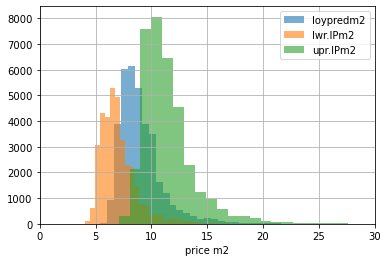

In [35]:
fig, ax = plt.subplots()
for var in ['loypredm2', 'lwr.IPm2', 'upr.IPm2'] :
    print("="*20)
    print(var)
    print('='*20)
    print(f"{var} minimum : {DATA_appart[var].min()}")
    print(f"{var} maximum : {DATA_appart[var].max()}")
    print(f"{var} moyen : {DATA_appart[var].mean()}")
    print(f"{var} médian : {DATA_appart[var].median()}")
    DATA_appart[var].hist(bins=50, ax=ax, alpha=0.6, label=var, ls='dashed')
plt.legend()
ax.set_xlim((0,30))
ax.set_xlabel("price m2")
plt.show()

#### Sauvegarde

In [38]:
DATA_appart.to_csv("database_loyer_cleaned.csv", sep=',',index=False)

#### Maison
on applique le même traitement que pour les appartements

In [39]:
print(f"Nombre de variables disponobles : {len(DATA_maison.columns)}")
print(f"Liste des variables : {', '.join(DATA_maison.columns)}")

Nombre de variables disponobles : 13
Liste des variables : id_zone, INSEE, LIBGEO, DEP, REG, EPCI, TYPPRED, loypredm2, lwr.IPm2, upr.IPm2, R2adj, Nbobs_maille, NBobs_commune


In [40]:
DATA_maison.head()

,id_zone,INSEE,LIBGEO,DEP,REG,EPCI,TYPPRED,loypredm2,lwr.IPm2,upr.IPm2,R2adj,Nbobs_maille,NBobs_commune
0,1131,1001,L'Abergement-Clémenciat,1,84,200069193,maille,"8,191701105","6,585771255","10,1892344","0,730537021",586,13
1,364,1002,L'Abergement-de-Varey,1,84,240100883,maille,"7,441198704","5,672104712","9,76206205","0,708214655",643,18
2,806,1004,Ambérieu-en-Bugey,1,84,240100883,commune,"8,411183934","6,291931917","11,2442436","0,728003593",610,465
3,501,1005,Ambérieux-en-Dombes,1,84,200042497,maille,"9,039551135","6,861075317","11,90971983","0,677776765",569,53
4,459,1006,Ambléon,1,84,200040350,maille,"8,058264927","6,438139908","10,08608613","0,744073948",1641,9


In [41]:
DATA_maison.describe()

,REG,Nbobs_maille,NBobs_commune
count,35441.000000,35441.000000,35441.00000
mean,52.332186,773.743179,40.43935
std,24.334885,241.057216,135.50427
min,1.000000,456.000000,0.00000
25%,28.000000,596.000000,3.00000
50%,44.000000,722.000000,10.00000
75%,76.000000,898.000000,31.00000
max,94.000000,6575.000000,6490.00000


#### Détections doublons

In [42]:
counts = DATA_maison['INSEE'].value_counts()
print(f"Nombre de doublons : {len(counts[counts > 1])}")

Nombre de doublons : 0


Une commune n'est pas présente deux fois.

#### Variables conservées
- INSEE : code INSEE de la commune
- LIBGEO : nom de la commune
- DEP : code département
- loypredm2
- lwr.IPm2
- upr.IPm2

In [43]:
variables = ['INSEE', 'LIBGEO', 'DEP', 'loypredm2', 'lwr.IPm2', 'upr.IPm2']
DATA_maison = DATA_maison[variables]

In [44]:
for var in ['loypredm2', 'lwr.IPm2', 'upr.IPm2'] :
    DATA_maison[var] = DATA_maison[var].apply(lambda x : x.replace(',','.'))
    DATA_maison[var] = DATA_maison[var].astype(float)

#### INSEE
Dans cette base de données Paris, Marseille et Lyon sont définies par arrondissement.  
On va récreer une ligne par moyenne pour la ville. 

In [45]:
for ville, dep in [("Paris", '75'), ('Marseille', '13'), ("Lyon", '69')] :
    code = DATA_com[DATA_com['LIBGEO'] == ville]['CODGEO'].values[0]
    new_row = {"INSEE" : code, 'LIBGEO' : ville, 'DEP' : dep}
    for var in ['loypredm2', 'lwr.IPm2', 'upr.IPm2'] :
        new_row[var] = DATA_maison[(DATA_maison['LIBGEO'].apply(lambda x : True if x.startswith(ville) else False)) & (DATA_maison['DEP']==dep)][var].mean()
    DATA_maison = DATA_maison.append(new_row, ignore_index=True)
DATA_maison

,INSEE,LIBGEO,DEP,loypredm2,lwr.IPm2,upr.IPm2
0,1001,L'Abergement-Clémenciat,1,8.191701,6.585771,10.189234
1,1002,L'Abergement-de-Varey,1,7.441199,5.672105,9.762062
2,1004,Ambérieu-en-Bugey,1,8.411184,6.291932,11.244244
3,1005,Ambérieux-en-Dombes,1,9.039551,6.861075,11.909720
4,1006,Ambléon,1,8.058265,6.438140,10.086086
...,...,...,...,...,...,...
35439,97423,Les Trois-Bassins,974,9.677387,7.237465,12.939863
35440,97424,Cilaos,974,7.607132,5.686818,10.175893
35441,75056,Paris,75,29.460230,14.518030,60.238237
35442,13055,Marseille,13,13.620770,10.065467,18.491178


In [46]:
print(DATA_maison['INSEE'].apply(len).value_counts())

5    32265
4     3179
Name: INSEE, dtype: int64


In [47]:
DATA_maison['INSEE_corr'] = DATA_maison['INSEE'].apply(lambda x : "0"+x if len(x) == 4 else x)

In [48]:
DATA_maison[~DATA_maison['INSEE_corr'].isin(DATA_com['CODGEO'].values)]

,INSEE,LIBGEO,DEP,loypredm2,lwr.IPm2,upr.IPm2,INSEE_corr
4449,13201,Marseille 1er Arrondissement,13,12.568708,9.142796,17.278349,13201
4450,13202,Marseille 2e Arrondissement,13,12.568708,9.142796,17.278349,13202
4451,13203,Marseille 3e Arrondissement,13,11.642087,8.428190,16.081530,13203
4452,13204,Marseille 4e Arrondissement,13,12.970477,9.448390,17.805496,13204
4453,13205,Marseille 5e Arrondissement,13,11.811248,9.698646,14.384027,13205
4454,13206,Marseille 6e Arrondissement,13,14.545388,10.281402,20.577767,13206
4455,13207,Marseille 7e Arrondissement,13,17.316202,12.234178,24.509277,13207
4456,13208,Marseille 8e Arrondissement,13,16.373587,11.274069,23.779732,13208
4457,13209,Marseille 9e Arrondissement,13,15.441778,11.159045,21.368182,13209
4458,13210,Marseille 10e Arrondissement,13,11.522414,9.458469,14.036735,13210


#### Prix loyer

loypredm2
loypredm2 minimum : 4.896744631
loypredm2 maximum : 38.08597384
loypredm2 moyen : 7.462147259824144
loypredm2 médian : 7.022981591
lwr.IPm2
lwr.IPm2 minimum : 2.970529548
lwr.IPm2 maximum : 30.23367012
lwr.IPm2 moyen : 5.739213763226861
lwr.IPm2 médian : 5.493500467
upr.IPm2
upr.IPm2 minimum : 6.104875382
upr.IPm2 maximum : 67.50168542
upr.IPm2 moyen : 9.745615050655044
upr.IPm2 médian : 9.036893834


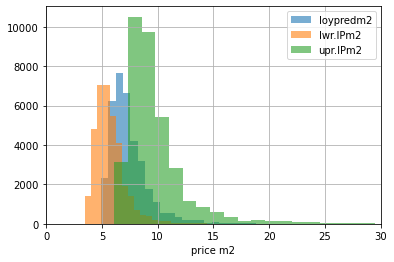

In [51]:
fig, ax = plt.subplots()
for var in ['loypredm2', 'lwr.IPm2', 'upr.IPm2'] :
    print("="*20)
    print(var)
    print('='*20)
    print(f"{var} minimum : {DATA_maison[var].min()}")
    print(f"{var} maximum : {DATA_maison[var].max()}")
    print(f"{var} moyen : {DATA_maison[var].mean()}")
    print(f"{var} médian : {DATA_maison[var].median()}")
    DATA_maison[var].hist(bins=50, ax=ax, alpha=0.6, label=var, ls='dashed')
plt.legend()
ax.set_xlim((0,30))
ax.set_xlabel("price m2")
plt.show()

#### Sauvegarde

In [176]:
DATA_maison.to_csv("database_loyer_maison_cleaned.csv", sep=',',index=False)

### Données transport

#### Variables disponibles

In [178]:
print(f"Nombre de variables disponibles : {len(DATA_transp.columns)}")
print(f"Liste des variables : {', '.join(DATA_transp.columns)}")

Nombre de variables disponibles : 39
Liste des variables : geo_point_2d, geo_shape, gares_id, nom_long, nom, nom_sous, nom_sur, id_ref_lda, nom_lda, id_ref_zdl, nom_zdl, num_mod, mode, fer, train, rer, metro, tramway, navette, val, terfer, tertrain, terrer, termetro, tertram, ternavette, terval, idrefliga, idrefligc, ligne, indice_lig, res_com, exploitant, idf, principal, x, y, picto, nom_iv


In [179]:
DATA_transp.head()

,geo_point_2d,geo_shape,gares_id,nom_long,nom,nom_sous,nom_sur,id_ref_lda,nom_lda,id_ref_zdl,nom_zdl,num_mod,mode,fer,train,rer,metro,tramway,navette,val,terfer,tertrain,terrer,termetro,tertram,ternavette,terval,idrefliga,idrefligc,ligne,indice_lig,res_com,exploitant,idf,principal,x,y,picto,nom_iv
0,"48.97066504740207,2.077731764565598","{""coordinates"": [2.077731764565598, 48.9706650...",6.0,Achères-Ville,Achères-Ville,NaN,NaN,73604.0,Achères Ville,46647.0,Achères Ville,0.0,RER,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,A01856,C01742,RER A,A,RER A,SNCF,1.0,0.0,632479.4115,6.874919e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Achères-Ville
1,"48.97066504740207,2.077731764565598","{""coordinates"": [2.077731764565598, 48.9706650...",7.0,Achères-Ville,Achères-Ville,NaN,NaN,73604.0,Achères Ville,46647.0,Achères Ville,0.0,TRAIN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,A02176,C01740,TRAIN L,L,TRAIN L,SNCF,1.0,0.0,632479.4115,6.874919e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Achères-Ville
2,"48.71262898655513,2.4036331049084922","{""coordinates"": [2.403633104908492, 48.7126289...",31.0,Athis-Mons,Athis-Mons,NaN,NaN,63134.0,Athis-Mons,46395.0,Athis-Mons,0.0,RER,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,A01840,C01727,RER C,C,RER C,SNCF,1.0,0.0,656121.8463,6.845998e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Athis-Mons
3,"48.8721574939563,2.329927170608276","{""coordinates"": [2.329927170608276, 48.8721574...",32.0,Auber,Auber,NaN,NaN,478926.0,Auber,45873.0,Auber,0.0,RER,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,A01856,C01742,RER A,A,RER A,RATP,1.0,0.0,650849.5187,6.863779e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Auber
4,"48.85955731595359,2.9057369645485345","{""coordinates"": [2.905736964548534, 48.8595573...",222.0,Crécy-la-Chapelle,Crécy-la-Chapelle,NaN,NaN,68293.0,Crécy-la-Chapelle,47894.0,Crécy-la-Chapelle,0.0,TRAIN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,TRAIN P,0,0,0,0,0,A01844,C01730,TRAIN P,P,TRAIN P,SNCF,1.0,1.0,693083.9625,6.862173e+06,https://data.iledefrance-mobilites.fr/api/v2/c...,Crécy-la-Chapelle


In [180]:
DATA_transp.describe()

,gares_id,id_ref_lda,id_ref_zdl,num_mod,fer,train,rer,metro,tramway,navette,val,terfer,idf,principal,x,y
count,1182.000000,1182.000000,1182.000000,1182.0,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.000000,1182.0,1182.000000,1182.000000,1182.000000,1.182000e+03
mean,627.302030,103708.828257,110498.402707,0.0,0.456007,0.237733,0.218274,0.329949,0.205584,0.008460,0.008460,0.0,0.956007,0.112521,651360.849461,6.860635e+06
std,366.850803,107013.713282,148945.176639,0.0,0.498272,0.425875,0.413249,0.470393,0.404299,0.091628,0.091628,0.0,0.205167,0.316140,17667.631880,1.748877e+04
min,1.000000,59403.000000,42142.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,564673.761000,6.762402e+06
25%,309.250000,68124.500000,43234.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,646384.800825,6.857465e+06
50%,618.500000,71297.000000,45288.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,651763.697000,6.862741e+06
75%,938.750000,72378.750000,50570.750000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,655658.577850,6.867580e+06
max,1263.000000,483315.000000,483901.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,738278.993500,6.925576e+06


#### Variables conservées
- geo_point_2d : localisation
- nom_long : nom 
- mode : mode de transport

In [181]:
variables = ['geo_point_2d', 'nom_long', 'mode']
DATA_transp = DATA_transp[variables]

#### Mode 

In [182]:
print(f"Nombre de valeurs manquantes : {DATA_transp[DATA_transp['mode'].isnull()]['mode'].sum()}")

Nombre de valeurs manquantes : 0


In [183]:
DATA_transp['mode'].value_counts(dropna=False)

METRO      390
TRAIN      281
RER        258
TRAMWAY    243
VAL         10
Name: mode, dtype: int64

<AxesSubplot:ylabel='mode'>

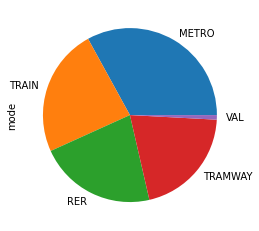

In [184]:
DATA_transp['mode'].value_counts(dropna=False).plot.pie()

In [185]:
DATA_transp = DATA_transp.drop(DATA_transp[DATA_transp['mode'].isnull()].index)

#### localisation

In [186]:
print(f"Nombre de valeurs manquantes : {DATA_transp[DATA_transp['geo_point_2d'].isnull()]['geo_point_2d'].sum()}")

Nombre de valeurs manquantes : 0


In [187]:
tmp = DATA_transp['geo_point_2d'].str.split(',', expand=True).values
DATA_transp['latitude'] = tmp[:,0]
DATA_transp['longitude'] = tmp[:,1]
DATA_transp['latitude'] = DATA_transp['latitude'].astype(float)
DATA_transp['longitude'] = DATA_transp['longitude'].astype(float)

latitude minimum : 47.9608881446465
latitude maximum : 49.426201591363856
latitude moyen : 48.84367318853106
latitude median : 48.862857237309555


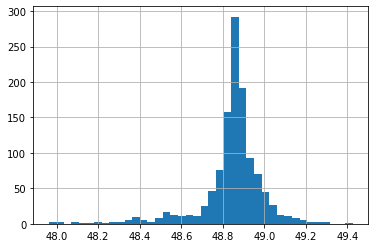

longitude minimum : 1.1497406055270256
longitude maximum : 3.5128887612894455
longitude moyen : 2.337095855791961
longitude median : 2.342143280377591


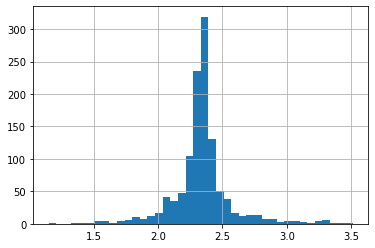

In [188]:
for par in ['latitude', 'longitude'] :
    print(f"{par} minimum : {DATA_transp[par].min()}")
    print(f"{par} maximum : {DATA_transp[par].max()}")    
    print(f"{par} moyen : {DATA_transp[par].mean()}")    
    print(f"{par} median : {DATA_transp[par].median()}")    
    fig, ax  = plt.subplots()
    DATA_transp[par].hist(bins=40, ax=ax)
    plt.show()

In [189]:
DATA_transp.drop(DATA_transp[DATA_transp['geo_point_2d'].isnull()].index, inplace=True)
DATA_transp.drop(DATA_transp[DATA_transp['latitude'].isnull()].index, inplace=True)
DATA_transp.drop(DATA_transp[DATA_transp['longitude'].isnull()].index, inplace=True)

#### Nom 

In [190]:
print(f"Nombre de valeurs manquantes : {DATA_transp[DATA_transp['nom_long'].isnull()]['nom_long'].sum()}")

Nombre de valeurs manquantes : 0


In [191]:
DATA_transp.drop(DATA_transp[DATA_transp['nom_long'].isnull()].index, inplace=True)

#### Sauvegarde

In [192]:
DATA_transp.to_csv("database_transport_cleaned.csv", sep=',',index=False)

### Données communes

#### Variables disponibles

In [193]:
print(f"Nombre de variables : {len(DATA_com.columns)}")

Nombre de variables : 101


In [194]:
print(f"Liste de variables : {', '.join(DATA_com.columns)}")

Liste de variables : CODGEO, Nb Pharmacies et parfumerie, Dynamique Entrepreneuriale, Dynamique Entrepreneuriale Service et Commerce, Synergie Médicale COMMUNE, Orientation Economique, Indice Fiscal Partiel, Score Fiscal, Indice Evasion Client, Score Evasion Client, Indice Synergie Médicale, Score Synergie Médicale, SEG Croissance POP, LIBGEO, REG, DEP, Nb Omnipraticiens BV, Nb Infirmiers Libéraux BV, Nb dentistes Libéraux BV, Nb pharmaciens Libéraux BV, Densité Médicale BV, Score équipement de santé BV, Indice Démographique, Score Démographique, Indice Ménages, Score Ménages, Population, Evolution Population, Evolution Pop %, Nb Ménages, Nb Résidences Principales, Nb propriétaire, Nb Logement, Nb Résidences Secondaires, Nb Log Vacants, Nb Occupants Résidence Principale, Nb Femme, Nb Homme, Nb Mineurs, Nb Majeurs, Nb Etudiants, Nb Entreprises Secteur Services, Nb Entreprises Secteur Commerce, Nb Entreprises Secteur Construction, Nb Entreprises Secteur Industrie, Nb Création Enteprises,

In [195]:
DATA_com.head()

,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,SEG Croissance POP,LIBGEO,REG,DEP,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Score Ménages,Population,Evolution Population,Evolution Pop %,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,Nb Log Vacants,Nb Occupants Résidence Principale,Nb Femme,Nb Homme,Nb Mineurs,Nb Majeurs,Nb Etudiants,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Moyenne Revenus Fiscaux Départementaux,Moyenne Revenus Fiscaux Régionaux,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Dep Moyenne Salaires Ouvrié Horaires,Reg Moyenne Salaires Horaires,Reg Moyenne Salaires Cadre Horaires,Reg Moyenne Salaires Prof Intermédiaire Horaires,Reg Moyenne Salaires Employé Horaires,Reg Moyenne Salaires Ouvrié Horaires,Valeur ajoutée régionale,Urbanité Ruralité,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,Dynamique Démographique BV,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fisc,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,SEG Environnement Démographique Obsolète,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,01001,0.0,57.0,23.0,114,Bassin Industriel,101.93878,59.04139,0.00000,0.00000,114.56713,0.13481,en croissance démographique,L' Abergement-Clémenciat,82,01,9,14,7,7,0.092860,4,44.19769,0.03410,37.22029,0.02223,725,16,2,247,248,196,289,32,9,728,694,714,909,499,51,7.0,11.0,2.0,2.0,4.0,0.0,2.0,1.0,1.0,12509,10458,11.410345,21.963793,12.558621,8.743103,9.268966,11.873022,21.78783,12.704057,8.783164,9.30142,86957.458359,Com rurale < 2 000 m habts,0.0,295.0,254.0,41.0,32.0,0.0,0.0,0.0,0.0,1.Accroissement par excédent naturel et migrat...,0,67,-1,117,117,11483.5,0,3.0,1.0,0.0,9364,9350,3372,15105,173681,Zone rurale en croissance démographique,72.13115,0.01585,32.42578,33.83811,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
1,01002,0.0,45.0,4.0,143,Bassin Résidentiel,101.93878,59.04139,0.00000,0.00000,143.71141,0.17351,en croissance démographique,L' Abergement-de-Varey,82,01,31,36,18,18,0.099229,4,10.18071,0.00786,10.09619,0.00603,167,4,2,67,67,61,142,71,4,168,162,164,202,124,5,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,12509,10458,11.410345,21.963793,12.558621,8.743103,9.268966,11.873022,21.78783,12.704057,8.783164,9.30142,86957.458359,Com rurale < 2 000 m habts,0.0,57.0,49.0,8.0,71.0,0.0,0.0,0.0,0.0,1.Accroissement par excédent naturel et migrat...,0,42,0,110,110,11483.5,0,0.0,0.0,0.0,9364,9350,3372,15105,173681,Zone rurale en croissance démographique,72.13115,0.00173,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
2,01004,0.0,634.0,

In [196]:
DATA_com.describe()

,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,REG,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Score Ménages,Population,Evolution Population,Evolution Pop %,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,Nb Log Vacants,Nb Occupants Résidence Principale,Nb Femme,Nb Homme,Nb Mineurs,Nb Majeurs,Nb Etudiants,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Moyenne Revenus Fiscaux Départementaux,Moyenne Revenus Fiscaux Régionaux,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Dep Moyenne Salaires Ouvrié Horaires,Reg Moyenne Salaires Horaires,Reg Moyenne Salaires Cadre Horaires,Reg Moyenne Salaires Prof Intermédiaire Horaires,Reg Moyenne Salaires Employé Horaires,Reg Moyenne Salaires Ouvrié Horaires,Valeur ajoutée régionale,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fisc,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB
count,36676.000000,36676.000000,36676.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,3.667700e+04,36677.000000,36677.000000,3.667700e+04,3.667700e+04,36677.000000,3.667700e+04,36677.000000,36677.000000,3.667700e+04,3.667700e+04,3.667700e+04,3.667700e+04,3.667700e+04,36677.000000,36676.000000,36676.000000,36676.000000,36676.000000,36676.000000,36676.000000,36676.000000,36676.000000,36676.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36662.000000,36662.000000,36662.000000,36565.000000,36565.000000,36565.000000,36565.000000,36565.000000,36677.000000,36677.00000,36677.000000,3.667700e+04,3.667700e+04,36677.000000,36677.000000,36676.000000,36676.000000,36676.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36677.000000,36676.000000,36677.000000,36677.000000
mean,0.066910,99.501254,99.502154,99.504976,100.000000,54.708029,100.000000,0.042750,100.000000,0.115459,49.448455,16.698203,16.609346,8.061074,8.061074,0.312984,2.527769,100.000000,0.077162,100.000000,0.059735,1.640357e+03,55.138207,-0.500477,6.636165e+02,6.637491e+02,363.475475,7.991823e+02,79.962974,55.469804,1.604442e+03,1.644076e+03,1.547716e+03,1.936272e+03,1.255520e+03,135.120566,40.357673,37.207111,10.546297,14.310857,8.752263,0.556549,1.442087,2.218208,4.535418,10353.940780,10259.098509,10.993566,21.208332,12.466669,8.664136,9.051206,11.166510,21.285042,12.522169,8.688338,9.113746,41466.784992,7.684993,640.954912,561.007965,79.946948,79.560727,0.476549,16.388322,0.218269,25.225489,0.027183,58.01655,-6.067944,-3.013264e+01,-3.013264e+01,10306.519644,0.804973,10.

In [197]:
count_nan = pd.DataFrame(columns=['variables', 'nan'])
for var in DATA_com.columns :
    nan = len(DATA_com[DATA_com[var].isnull()])
    count_nan = count_nan.append({'variables' : var, 'nan': nan}, ignore_index=True)
count_nan.sort_values('nan', ascending=False)

,variables,nan
71,Nb Camping,112
70,Capacité Hotel,112
72,Capacité Camping,112
69,Nb Hotel,112
68,Nb Logement Secondaire et Occasionnel,112
...,...,...
30,Nb Résidences Principales,0
29,Nb Ménages,0
28,Evolution Pop %,0
27,Evolution Population,0


#### Variables conservées
- CODGEO : code commune
- LIBGEO 
- DEP 
- Nb Pharmacies et parfumerie
- Score Synergie Médicale
- Score équipement de santé BV
- Score Démographique
- Evolution Pop %
- Taux Propriété
- Dynamique Démographique INSEE
- Taux étudiants

In [198]:
variables = ['CODGEO', 'LIBGEO', 'DEP','Nb Pharmacies et parfumerie', 'Score Synergie Médicale', 'Score équipement de santé BV',\
            'Score Démographique', 'Evolution Pop %', 'Dynamique Démographique INSEE','Taux étudiants', 'Taux Propriété']
DATA_com = DATA_com[variables]

#### Départements
On conserve uniquement les communes du 91.

In [199]:
DATA_com = DATA_com[DATA_com['DEP'] == '91']

In [200]:
print(f"Nombre de villes conservées : {len(DATA_com)}")

Nombre de villes conservées : 196


#### Nombre de pharmacies

In [201]:
print(f"Nombre de pharmacie minimum : {DATA_com['Nb Pharmacies et parfumerie'].min()}")
print(f"Nombre de pharmacie maximum : {DATA_com['Nb Pharmacies et parfumerie'].max()}")
print(f"Nombre de pharmacie moyen : {DATA_com['Nb Pharmacies et parfumerie'].mean()}")
print(f"Nombre de pharmacie médian : {DATA_com['Nb Pharmacies et parfumerie'].median()}")
print(f"Nombre de valeurs manquantes {len(DATA_com[DATA_com['Nb Pharmacies et parfumerie'].isnull()])}")

Nombre de pharmacie minimum : 0.0
Nombre de pharmacie maximum : 2.0
Nombre de pharmacie moyen : 0.16326530612244897
Nombre de pharmacie médian : 0.0
Nombre de valeurs manquantes 0


<AxesSubplot:>

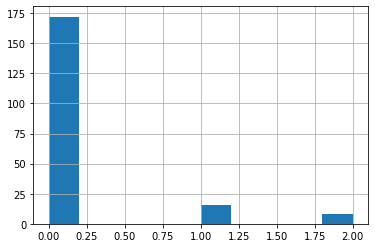

In [202]:
DATA_com['Nb Pharmacies et parfumerie'].hist()

Le nombre de pharmacies par ville semble très faible, et il est peu probable que le nombre maximum de pharmacie par communes en Essonne soit 2. On décide de supprimer cette observation.

In [203]:
DATA_com.drop('Nb Pharmacies et parfumerie', axis='columns', inplace=True)

#### Autres variables 

Score Synergie Médicale
Score Synergie Médicale minimum : 0.30164
Score Synergie Médicale maximum : 1.30134
Score Synergie Médicale moyen : 0.42562081632653037
Score Synergie Médicale median : 0.37372
Nombre de valeurs manquantes 0


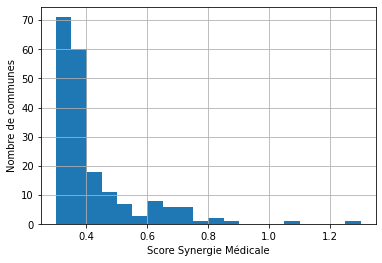

Score équipement de santé BV
Score équipement de santé BV minimum : 0
Score équipement de santé BV maximum : 4
Score équipement de santé BV moyen : 1.780612244897959
Score équipement de santé BV median : 1.0
Nombre de valeurs manquantes 0


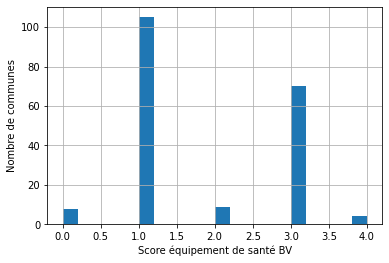

Score Démographique
Score Démographique minimum : 0.00268
Score Démographique maximum : 2.32363
Score Démographique moyen : 0.27216617346938754
Score Démographique median : 0.08554500000000001
Nombre de valeurs manquantes 0


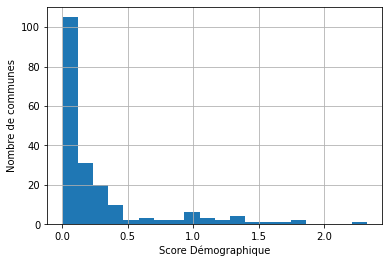

Evolution Pop %
Evolution Pop % minimum : -12
Evolution Pop % maximum : 17
Evolution Pop % moyen : 3.8469387755102042
Evolution Pop % median : 3.0
Nombre de valeurs manquantes 0


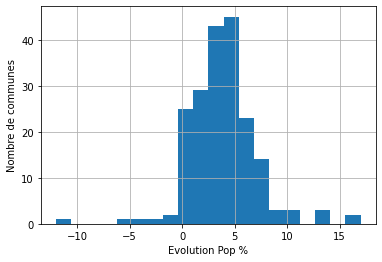

Dynamique Démographique INSEE
Dynamique Démographique INSEE minimum : -842
Dynamique Démographique INSEE maximum : 19
Dynamique Démographique INSEE moyen : -45.58673469387755
Dynamique Démographique INSEE median : -5.0
Nombre de valeurs manquantes 0


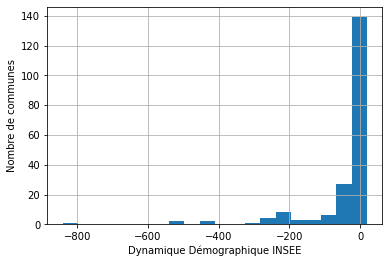

Taux étudiants
Taux étudiants minimum : 0
Taux étudiants maximum : 2
Taux étudiants moyen : 0.08673469387755102
Taux étudiants median : 0.0
Nombre de valeurs manquantes 0


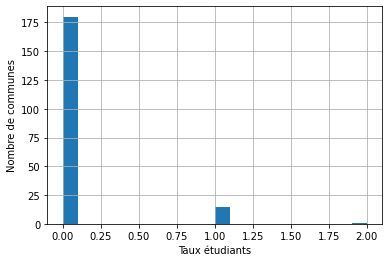

Taux Propriété
Taux Propriété minimum : 16
Taux Propriété maximum : 86
Taux Propriété moyen : 65.59693877551021
Taux Propriété median : 69.0
Nombre de valeurs manquantes 0


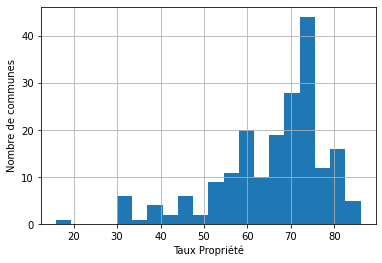

In [204]:
for var in ['Score Synergie Médicale', 'Score équipement de santé BV', 'Score Démographique', 'Evolution Pop %', \
            'Dynamique Démographique INSEE','Taux étudiants', 'Taux Propriété']:
    print("="*50)
    print(var)
    print('='*50)
    print(f"{var} minimum : {DATA_com[var].min()}")
    print(f"{var} maximum : {DATA_com[var].max()}")
    print(f"{var} moyen : {DATA_com[var].mean()}")
    print(f"{var} median : {DATA_com[var].median()}")
    print(f"Nombre de valeurs manquantes {len(DATA_com[DATA_com[var].isnull()])}")
    fig, ax = plt.subplots()
    DATA_com[var].hist(bins=20, ax=ax)
    ax.set_xlabel(var)
    ax.set_ylabel('Nombre de communes')
    plt.show()

Le taux d'étudiants ne semble pas être une variable assez disciminantes : on la supprime.

In [205]:
DATA_com.drop('Taux étudiants', axis='columns', inplace=True)

#### Sauvegarde de la base de données nettoyées

In [206]:
DATA_com.to_csv("database_communes_cleaned.csv", sep=',',index=False)

## Nouvelles variables

In [207]:
DATA_immo = pd.read_csv("database_ventes_immo_cleaned.csv", sep=',', index_col=False)

In [208]:
DATA_transp = pd.read_csv("database_transport_cleaned.csv", sep=',', index_col=False)

In [209]:
DATA_com = pd.read_csv("database_communes_cleaned.csv", sep=',', index_col=False)

In [210]:
DATA_appart = pd.read_csv("database_loyer_cleaned.csv", sep=',', index_col=False)

In [211]:
DATA_maison = pd.read_csv("database_loyer_maison_cleaned.csv", sep=',', index_col=False)

In [212]:
DATA_ecole = pd.read_csv("database_ecoles.csv", sep=',', index_col=False)

In [213]:
DATA_univ = pd.read_csv("database_universites_cleaned.csv", sep=',', index_col=False)

In [214]:
DATA = DATA_immo.copy(deep=True)

### Date depuis l'opération
Puisque les données sont disponibles jusqu'au 31/12/21, on créé une variable qui compte le nombre de jour depuis le 01/01/22.

In [215]:
date = datetime.datetime(2022, 1, 1)

In [216]:
DATA['date_mutation']= DATA['date_mutation'].astype('datetime64[ns]')

In [217]:
DATA['n_days'] = (date-DATA['date_mutation']).dt.days

In [218]:
DATA.drop('date_mutation', axis='columns', inplace=True)

### Combiner les ventes avec les données sur les communes

In [219]:
DATA.rename(columns={"code_commune": 'CODGEO'}, inplace=True)

In [220]:
DATA = DATA.merge(DATA_com, on='CODGEO')

In [221]:
DATA.head()

,id_mutation,surface_reelle_bati,valeur_fonciere,code_departement,nombre_lots,n_lignes,nombre_pieces_principales,surface_terrain,longitude,latitude,nature_mutation,CODGEO,Dépendance,type_local,année,mois,n_days,LIBGEO,DEP,Score Synergie Médicale,Score équipement de santé BV,Score Démographique,Evolution Pop %,Dynamique Démographique INSEE,Taux Propriété
0,2017-1258468,28.0,70500.0,91,2,2,1.0,0.0,2.479872,48.597344,Vente,91174,1.0,Appartement,2017,1,1824,Corbeil-Essonnes,91,0.89158,1,1.85262,9,-431,31
1,2017-1258471,48.0,82000.0,91,2,1,3.0,0.0,2.476406,48.616450,Vente,91174,0.0,Appartement,2017,1,1822,Corbeil-Essonnes,91,0.89158,1,1.85262,9,-431,31
2,2017-1258480,85.0,233000.0,91,0,1,4.0,648.0,2.470152,48.594897,Vente,91174,0.0,Maison,2017,1,1821,Corbeil-Essonnes,91,0.89158,1,1.85262,9,-431,31
3,2017-1258488,48.0,107000.0,91,2,2,2.0,0.0,2.486500,48.602800,Vente,91174,1.0,Appartement,2017,1,1816,Corbeil-Essonnes,91,0.89158,1,1.85262,9,-431,31
4,2017-1258494,34.0,86500.0,91,1,1,2.0,0.0,2.476223,48.603752,Vente,91174,0.0,Appartement,2017,1,1816,Corbeil-Essonnes,91,0.89158,1,1.85262,9,-431,31


Le département est rappelé deux fois, on supprime une variable

In [222]:
DATA.drop('code_departement', axis='columns', inplace=True)

### Données sur les loyers

In [223]:
DATA_appart.rename(columns={'INSEE_corr': 'CODGEO'}, inplace=True)

In [224]:
DATA_maison.rename(columns={'INSEE_corr': 'CODGEO'}, inplace=True)

In [225]:
DATA_appart.head()

,INSEE,LIBGEO,DEP,loypredm2,lwr.IPm2,upr.IPm2,CODGEO
0,1001,L'Abergement-Clémenciat,1,9.372335,7.409664,11.854880,01001
1,1002,L'Abergement-de-Varey,1,8.635552,6.721078,11.095358,01002
2,1004,Ambérieu-en-Bugey,1,10.074507,7.865307,12.904225,01004
3,1005,Ambérieux-en-Dombes,1,9.372335,7.409664,11.854880,01005
4,1006,Ambléon,1,8.966955,7.101593,11.322287,01006


On sélectionne les variables à fusionner : 
- loypredm2
- lwr.IPm2
- upr.IPm2

In [226]:
DATA['CODGEO'] = DATA['CODGEO'].astype(str)

In [227]:
tmp_appart = DATA[DATA.type_local == "Appartement"].merge(DATA_appart[['CODGEO', 'loypredm2', 'lwr.IPm2', 'upr.IPm2']], on="CODGEO")
tmp_maison = DATA[DATA.type_local == "Maison"].merge(DATA_maison[['CODGEO', 'loypredm2', 'lwr.IPm2', 'upr.IPm2']], on="CODGEO")

In [228]:
DATA = tmp_appart.append(tmp_maison)

In [229]:
#DATA = DATA.merge(DATA_appart[['CODGEO', 'loypredm2', 'lwr.IPm2', 'upr.IPm2']], on="CODGEO")

### Création des loyers estimés

In [230]:
DATA['loyer_moyen'] = DATA['surface_reelle_bati']*DATA['loypredm2']
DATA['loyer_min'] = DATA['surface_reelle_bati']*DATA['lwr.IPm2']
DATA['loyer_max'] = DATA['surface_reelle_bati']*DATA['upr.IPm2']

On peut ensuite supprimer les données sur les loyers au m2.

In [231]:
DATA.drop(['loypredm2', 'lwr.IPm2', 'upr.IPm2'], axis=1, inplace=True)

### Distances

In [232]:
def calc_dist(arr1, arr2) :
    arr2 = arr2.reshape(-1,2)
    print(arr2)
    print(arr2.shape)
    result = haversine_distances(arr1, arr2)
    return result * 6371 # return distances in kilometers

In [233]:
def calc_distances(lat1, lon1, lat2, lon2) :
    coord1 = np.zeros((len(lat1) ,2))
    coord1[:,0] = lat1.values
    coord1[:,1] = lon1.values
    coord2 = np.zeros((len(lat2) ,2))
    coord2[:,0] = lat2.values
    coord2[:,1] = lon2.values
    result = haversine_distances(coord1, coord2)
    return result * 6371 # return distances in kilometers

In [234]:
DATA['longitude_rad'] = np.radians(DATA['longitude'])
DATA['latitude_rad'] = np.radians(DATA['latitude'])

In [235]:
DATA_transp['longitude_rad'] = np.radians(DATA_transp['longitude'])
DATA_transp['latitude_rad'] = np.radians(DATA_transp['latitude'])

In [236]:
DATA_ecole['latitude_rad'] = np.radians(DATA_ecole['Latitude'])
DATA_ecole['longitude_rad'] = np.radians(DATA_ecole['Longitude'])

In [237]:
DATA_univ['latitude_rad'] = np.radians(DATA_univ['latitude'])
DATA_univ['longitude_rad'] = np.radians(DATA_univ['longitude'])

#### Distances gares

In [238]:
distances = calc_distances(DATA['latitude_rad'], DATA['longitude_rad'],\
                           DATA_transp['latitude_rad'], DATA_transp['longitude_rad'])

In [239]:
dist_transp = []
mode_transp = []
arg_sort = np.argmin(distances, axis=1)
dist_min = np.sort(distances, axis=1)[:,0]
for i in range(len(DATA)) :
    dist_transp.append(dist_min[i])
    mode_transp.append(DATA_transp.iloc[arg_sort[i]]['mode'])
DATA['dist_transport'] = dist_transp
DATA['mode_transport'] = mode_transp

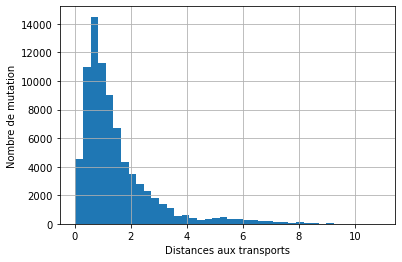

In [240]:
fig, ax = plt.subplots()
DATA['dist_transport'].hist(bins=40, ax=ax)
ax.set_xlabel('Distances aux transports')
ax.set_ylabel("Nombre de mutation")
plt.show()

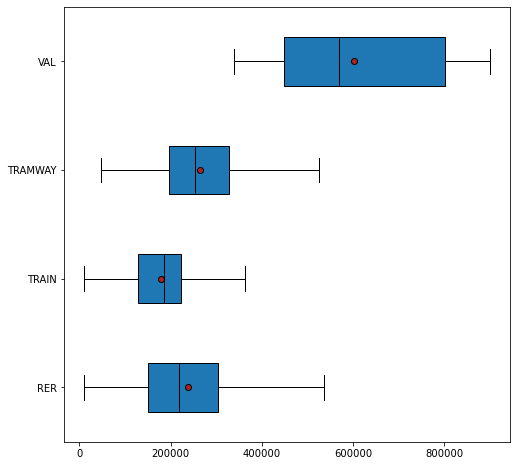

In [241]:
fig, ax = plt.subplots(figsize=(8,8))
data = DATA[pd.notnull(DATA['mode_transport'])]
data = data[pd.notnull(data['valeur_fonciere'])]
modalites = np.sort(data['mode_transport'].unique())
groupes = []
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
             'markerfacecolor':'firebrick'}

for mod in modalites : 
    groupes.append(data[data['mode_transport']==mod]['valeur_fonciere'])
ax.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

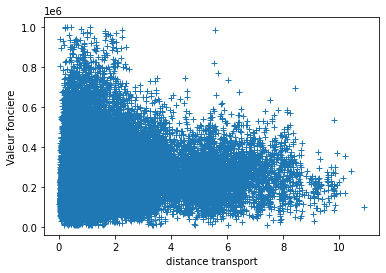

,dist_transport,valeur_fonciere
dist_transport,1.000000,0.108244
valeur_fonciere,0.108244,1.000000


In [242]:
fig, ax = plt.subplots()
ax.plot(DATA['dist_transport'], DATA['valeur_fonciere'], marker='+', linestyle='')
ax.set_xlabel('distance transport')
ax.set_ylabel('Valeur fonciere')
plt.show()
DATA[['dist_transport', 'valeur_fonciere']].corr()

### distances écoles

ecole_elementaire


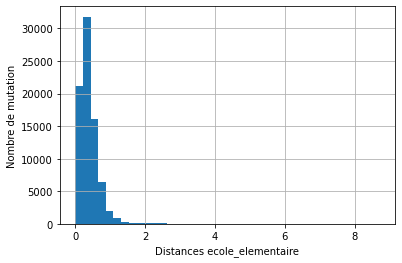

ecole_maternelle


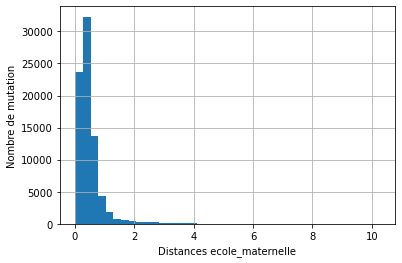

college


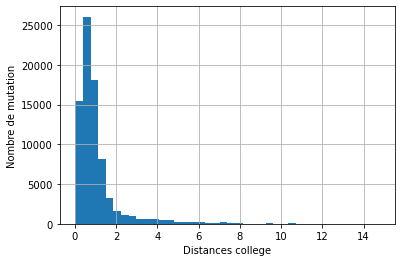

lycee


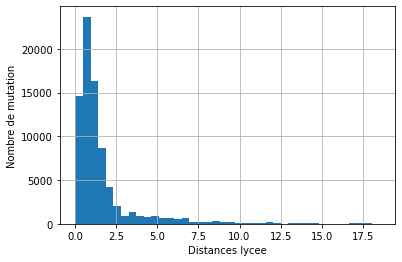

In [243]:
for niveau in DATA_ecole['niveau'].value_counts().index :
    print("="*50)
    print(niveau)
    print("="*50)
    distances = calc_distances(DATA['latitude_rad'], DATA['longitude_rad'],\
                               DATA_ecole[DATA_ecole['niveau'] == niveau]['latitude_rad'],
                               DATA_ecole[DATA_ecole['niveau'] == niveau]['longitude_rad'])
    DATA[f'dist_{niveau}'] = np.sort(distances, axis=1)[:,0]
    fig, ax = plt.subplots()
    DATA[f'dist_{niveau}'].hist(bins=40, ax=ax)
    ax.set_xlabel(f'Distances {niveau}')
    ax.set_ylabel("Nombre de mutation")
    plt.show()

#### Universités

In [244]:
distances = calc_distances(DATA['latitude_rad'], DATA['longitude_rad'],\
                           DATA_univ['latitude_rad'], DATA_univ['longitude_rad'])

In [245]:
DATA['dist_univ'] = np.sort(distances,axis=1)[:,0]

In [246]:
n_etudiant = []
n_etab = []
for i in range(len(DATA)):
    ma = distances[i,:]<10
    n_etab.append(np.sum(ma))
    n_etudiant.append(DATA_univ[ma]['inscrits_moyen'].sum())
DATA['n_etudiants_10km'] = n_etudiant
DATA['n_etab_sup_10km'] = n_etab

### sauvegarde

In [247]:
for col in DATA.columns :
    if col.startswith('Unnamed'):
        DATA.drop(col, axis='columns', inplace=True)

In [248]:
DATA.to_csv('database_training.csv', sep=',', index=False)